## Contents:

1. Data Exploration
2. Data Visualisation
3. Features engineering
4. ML
5. ML test function
6. Interpretability

# 0. Loading of librairies

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# Classification models that will be used
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from joblib import dump, load

# Models evaluation
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc

ModuleNotFoundError: No module named 'joblib'

# 1. Data Exploration & Cleaning

In [22]:
#1er look of the dataset
url = "https://raw.githubusercontent.com/fadilnjimoun/PyBet_Bet/main/Data/atp_data.csv"
df = pd.read_csv(url)
display(df.iloc[:,:10].head(2))
display(df.iloc[:,10:].head(2))

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Kiefer N.


,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
0,Ljubicic I.,63,77,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
1,Tarango J.,6,59,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5


In [4]:
# Some information on the variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44708 entries, 0 to 44707
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ATP         44708 non-null  int64  
 1   Location    44708 non-null  object 
 2   Tournament  44708 non-null  object 
 3   Date        44708 non-null  object 
 4   Series      44708 non-null  object 
 5   Court       44708 non-null  object 
 6   Surface     44708 non-null  object 
 7   Round       44708 non-null  object 
 8   Best of     44708 non-null  int64  
 9   Winner      44708 non-null  object 
 10  Loser       44708 non-null  object 
 11  WRank       44708 non-null  int64  
 12  LRank       44708 non-null  int64  
 13  Wsets       44521 non-null  float64
 14  Lsets       44521 non-null  float64
 15  Comment     44708 non-null  object 
 16  PSW         32743 non-null  float64
 17  PSL         32743 non-null  float64
 18  B365W       39037 non-null  float64
 19  B365L       39057 non-nul

##### We have 23 variables, 13 of whom continuous (quantitatives) et 10 categoricals (qualitatives)

In [5]:
# The dataset does not have a priori description, let us try to understand the different variables and describe them

df.nunique()

ATP              69
Location        115
Tournament      207
Date           4104
Series            8
Court             2
Surface           4
Round             8
Best of           2
Winner          899
Loser          1400
WRank           587
LRank           920
Wsets             4
Lsets             3
Comment           4
PSW            1177
PSL            1580
B365W           133
B365L           137
elo_winner    44297
elo_loser     43522
proba_elo     44555
dtype: int64

In [6]:
# Variable 'Comment'
df.Comment.unique()
# This variable lets you know if the match has come to an end

array(['Completed', 'Retired', 'Walkover', 'Disqualified'], dtype=object)

In [7]:
# Variable 'Series'
df.Series.unique()
# Tournament type

array(['International', 'Grand Slam', 'International Gold', 'Masters',
       'Masters Cup', 'ATP250', 'ATP500', 'Masters 1000'], dtype=object)

In [8]:
# Variable 'Round'
df.Round.unique()
# Competition stage

array(['1st Round', 'Semifinals', 'Quarterfinals', '2nd Round',
       'The Final', '3rd Round', '4th Round', 'Round Robin'], dtype=object)

In [9]:
# Variable 'Winner'
df.Winner.sort_values().unique()

array([' Hajek J.', 'Abel M.', 'Acasuso J.', 'Agassi A.', 'Agenor R.',
       'Aguilar J.', 'Ahouda A.', 'Al Ghareeb M.', 'Alami K.', 'Albot R.',
       'Aldi F.', 'Allegro Y.', 'Almagro N.', 'Alonso J.', 'Altmaier D.',
       'Alund M.', 'Alvarez E.', 'Alves T.', 'Amritraj P.', 'Ancic I.',
       'Ancic M.', 'Andersen J.F.', 'Anderson K.', 'Andreev I.',
       'Andreozzi G.', 'Andujar P.', 'Arazi H.', 'Arguello F.',
       'Armando H.', 'Arnaboldi A.', 'Arthurs W.', 'Ascione A.',
       'Ascione T.', 'Auckland J.', 'Baccanello P.', 'Bachelot J.F',
       'Bachinger M.', 'Baghdatis M.', 'Bagnis F.', 'Bai Y.', 'Baker B.',
       'Baker J.', 'Balazs A.', 'Balcells J.', 'Ball C.', 'Balleret B.',
       'Barton M.', 'Basic M.', 'Basilashvili N.', 'Bastl G.',
       'Bautista Agut R.', 'Bautista R.', 'Beck A.', 'Beck K.',
       'Becker B.', 'Bedene A.', 'Behrend T.', 'Bellucci T.',
       'Bemelmans R.', 'Benneteau J.', 'Berankis R.', 'Berasategui A.',
       'Berdych T.', 'Berdych T. ', '

##### There are duplicates for the following reasons:

- Spaces before and after some names. Ex: "Federer". Solution: Remove spaces
- Forgotten abbreviation points. Ex: 'Marin J.A', 'Marin J.A.'. Solution: Add the points
- Dashes forgotten on compound names. Ex: 'Carreno-Busta P.'. Solution: Add the dashes


Let us apply to this column of functions which correct these errors.

In [10]:
def remove_space(nom):
    if type(nom) == str:
        resultat = nom
        if nom[0] == ' ':
            resultat = nom[1:]
        if resultat[-1] == ' ':
            resultat = resultat[:-1]
        return resultat
    return nom

def add_mark(nom):
    if type(nom) == str:
        if nom[-1] != '.' and nom != np.nan:
            return nom + '.'
        return nom
    return nom

def add_dash(nom):
    if type(nom) == str:
        compteur = 0
        indice = 0
        for i,j in enumerate(reversed(nom)):
            if j == ' ':
                compteur += 1
                indice = i
        if compteur == 2:
            return nom[:indice-1] + '-' + nom[indice:]
    return nom

In [11]:
df[['Winner', 'Loser']] = df.apply({'Winner' : remove_space, 'Loser' : remove_space})
df[['Winner', 'Loser']] = df.apply({'Winner' : add_dash, 'Loser' : add_dash})
df[['Winner', 'Loser']] = df.apply({'Winner' : add_mark, 'Loser' : add_mark})

In [12]:
# Variable 'PSW'
display(df.PSW.sort_values().unique())
df.iloc[:,10:].loc[df.PSW >1]

# 'PS_', 'B365_' bookmakers odds

array([ 1.   ,  1.007,  1.008, ..., 41.   , 46.   ,    nan])

,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
8678,Kiefer N.,246,58,2.0,0.0,Completed,2.210,1.719,2.200,1.615,1486.195239,1618.182210,0.318694
8679,Schuettler R.,43,6,2.0,0.0,Completed,3.250,1.385,2.875,1.364,1615.057648,1820.759485,0.234313
8680,Carraz G.,39,67,2.0,1.0,Completed,1.746,2.180,1.571,2.250,1654.468551,1588.330984,0.594046
8682,Pless K.,97,440,2.0,0.0,Completed,1.562,2.580,1.571,2.250,1533.308961,1473.299803,0.585511
8683,Portas A.,111,85,2.0,0.0,Completed,1.641,2.360,1.570,2.250,1401.283125,1418.621881,0.475068
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44703,Pouille L.,23,15,2.0,0.0,Completed,1.650,2.430,1.660,2.200,1835.901543,1842.459807,0.490563
44704,Donaldson J.,8,59,2.0,1.0,Completed,1.340,3.630,1.300,3.500,1843.576914,1647.967561,0.755103
44705,Zeballos H.,73,69,2.0,1.0,Completed,1.850,2.090,1.900,1.900,1588.293069,1619.758421,0.454841
44706,Anderson K.,9,8,2.0,0.0,Completed,1.520,2.750,1.500,2.620,1966.532849,1851.413609,0.659862


In [15]:
# Variable 'elo_', 'proba_elo' : elo ranking

In [17]:
# Description des variables
""" 
0 ATP : ATP number of the tournament
1 Location : City's match
2 Tournament : Tournament name 
3 Date : Match day 
4 Series : Tournament type
5 Court : Indoor / Outdoor 
6 Surface : Pitch type
7 Round : Competition stage
8 Best of : Best score
9 Winner : Match winner 
10 Loser : Match loser 
11 WRank : Winner ATP rankig   
12 LRank : Loser ATP rankig
13 Wsets : Winner score
14 Lsets : Loser score
15 Comment : Finshed or unfinished match ? """

" \n0 ATP : Numéro ATP du tournoi\n1 Location : lieu (ville) où s'est tenue match\n2 Tournament : Non du tournoi \n3 Date : date à laquelle a eu lieu le match \n4 Series : Type de tournoi\n5 Court : Intérieur / Extérieur \n6 Surface : Type de terrain\n7 Round : Etape de la compétition\n8 Best of : Nombre de sets max ?\n9 Winner : Vainqueur du match \n10 Loser : perdant du match \n11 WRank : Classement ATP du gagnant au moment de la victoire   \n12 LRank : Classement ATP du perdant au moment de la victoire \n13 Wsets : Sets remportés par le gagnant\n14 Lsets : Sets remportés par le perdant\n15 Comment : Permet de savoir si le match est alors à son terme \n\n\n16 PSW        \n17 PSL        \n18 B365W      \n19 B365L      \n20 elo_winner \n21 elo_loser  \n22 proba_elo : Probabilité de l'outsider de gagner ou probabilité du challenger de perdre ?????"

In [18]:
# Duplicates presence ?
df.duplicated().sum()

0

### Missing values

In [19]:
# Missing values presence
df.isnull().sum()

ATP               0
Location          0
Tournament        0
Date              0
Series            0
Court             0
Surface           0
Round             0
Best of           0
Winner            0
Loser             0
WRank             0
LRank             0
Wsets           187
Lsets           187
Comment           0
PSW           11965
PSL           11965
B365W          5671
B365L          5651
elo_winner        0
elo_loser         0
proba_elo         0
dtype: int64

In [20]:
df.isnull().sum()

ATP               0
Location          0
Tournament        0
Date              0
Series            0
Court             0
Surface           0
Round             0
Best of           0
Winner            0
Loser             0
WRank             0
LRank             0
Wsets           187
Lsets           187
Comment           0
PSW           11965
PSL           11965
B365W          5671
B365L          5651
elo_winner        0
elo_loser         0
proba_elo         0
dtype: int64

##### The uncompleted matches or whose socre are not known are a limited interest in the card of this analysis.
#### Thus, we are going to focus on the matches including "How = 'Completed'" and whose scores are known.

In [21]:
df1 = df.loc[(df.Comment == 'Completed') & (df.Wsets.notna()) & (df.Lsets.notna())]

display(df1.iloc[:,:10].head(2))
display(df1.iloc[:,10:].head(2))

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Kiefer N.


,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
0,Ljubicic I.,63,77,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
1,Tarango J.,6,59,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5


In [22]:
# Sometimes we miss values for B365 and not for PS, and vice versa.
# We choose first to replace missing values of one bookmaker with the values of the other bookmaker.

In [23]:
df1.loc[(df1.B365W.isna()==True) & (df1.PSW > 0), 'B365W'] = df1.loc[(df1.B365W.isna()==True) & (df1.PSW > 0), 'PSW']
df1.loc[(df1.B365L.isna()==True) & (df1.PSW > 0), 'B365L'] = df1.loc[(df1.B365L.isna()==True) & (df1.PSW > 0), 'PSL']
df1.loc[(df1.PSL.isna()==True) & (df1.B365W > 0), 'PSL'] = df1.loc[(df1.PSL.isna()==True) & (df1.B365W > 0), 'B365L']
df1.loc[(df1.PSW.isna()==True) & (df1.B365W > 0), 'PSW'] = df1.loc[(df1.PSW.isna()==True) & (df1.B365W > 0), 'B365W']

In [24]:
df1.isna().sum()

ATP              0
Location         0
Tournament       0
Date             0
Series           0
Court            0
Surface          0
Round            0
Best of          0
Winner           0
Loser            0
WRank            0
LRank            0
Wsets            0
Lsets            0
Comment          0
PSW           5087
PSL           5087
B365W         5087
B365L         5087
elo_winner       0
elo_loser        0
proba_elo        0
dtype: int64

###### Lets replace remaining missing odds values by 1

In [25]:
bookmakers = ['PSW', 'PSL', 'B365W', 'B365L']
for i in bookmakers:
    df1[i].fillna(1, axis=0, inplace=True)
df1.isna().sum().sum()

C:\Users\00080609\AppData\Local\Temp\ipykernel_10132\1218725977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[i].fillna(1, axis=0, inplace=True)


0

In [26]:
# Les variables Wsets et Lsets sont de type 'float'. Elles devraient être de type 'int'.
# La variable Date n'a pas le bon type également
df1 = df1.astype({'Wsets' : 'int', 'Lsets' : 'int', 'Date' : 'datetime64'})

##### Description rapide des varibles

In [27]:
display(df1.describe(include=[np.number])) # Description des variables numériques

display(df1.describe(exclude=[np.number])) # Description des variables catégroielles

,ATP,Best of,WRank,LRank,Wsets,Lsets,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
count,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000,43014.000000
mean,32.773004,3.369833,58.853559,94.464523,2.184893,0.411540,1.786088,3.727550,1.712667,3.269369,1684.866154,1607.389932,0.588200
std,18.174624,0.776469,74.376858,125.461112,0.388694,0.559003,1.231010,5.156139,1.052423,3.414754,179.382693,137.488328,0.197758
min,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1318.945207,1327.551888,0.008899
25%,19.000000,3.000000,16.000000,35.000000,2.000000,0.000000,1.167000,1.560000,1.140000,1.500000,1549.287096,1500.768657,0.451174
50%,32.000000,3.000000,41.000000,66.000000,2.000000,0.000000,1.444000,2.380000,1.400000,2.250000,1653.976062,1578.913083,0.591985
75%,49.000000,3.000000,77.000000,106.000000,2.000000,1.000000,1.962000,3.850000,1.900000,3.750000,1781.647774,1683.075379,0.739046
max,69.000000,5.000000,1890.000000,2000.000000,3.000000,2.000000,46.000000,121.000000,29.000000,101.000000,2392.408923,2383.577360,0.995601


C:\Users\00080609\AppData\Local\Temp\ipykernel_10132\314419191.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(df1.describe(exclude=[np.number])) # Description des variables catégroielles


,Location,Tournament,Date,Series,Court,Surface,Round,Winner,Loser,Comment
count,43014,43014,43014,43014,43014,43014,43014,43014,43014,43014
unique,115,207,4100,8,2,4,8,853,1329,1
top,Paris,Australian Open,2000-01-17 00:00:00,International,Outdoor,Hard,1st Round,Federer R.,Lopez F.,Completed
freq,2660,2067,124,10400,35138,22892,19920,945,360,43014
first,NaN,NaN,2000-01-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2018-03-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Data Visualisation

### 2.1. Players with the most victories

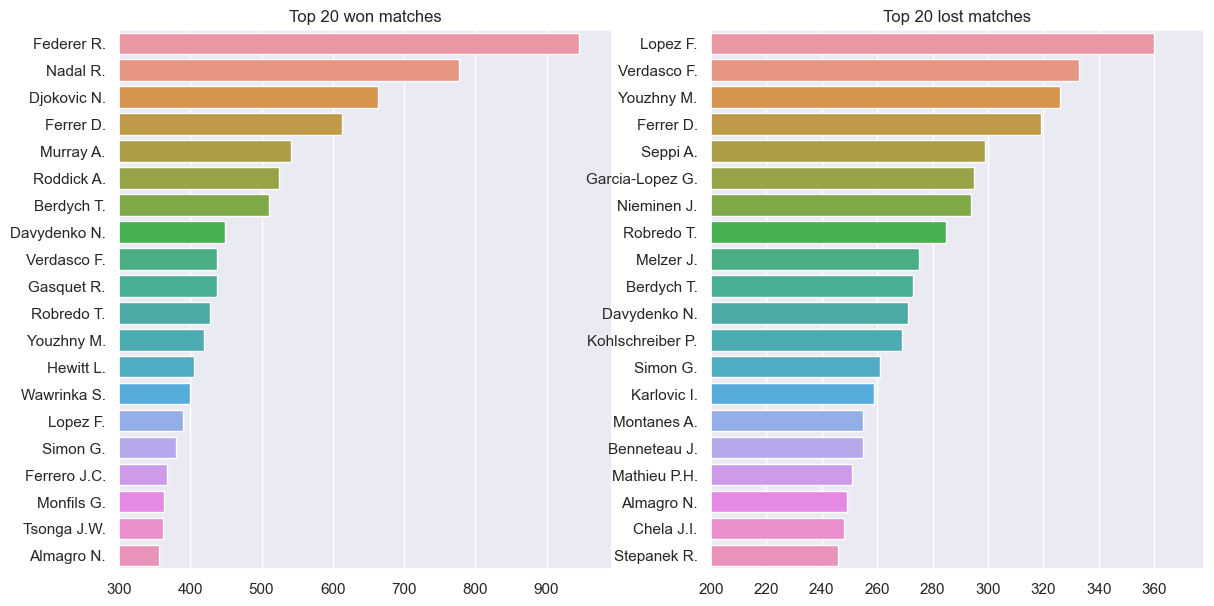

In [28]:
# Les joueurs (Top 20) ayant gagné le plus de matchs
sns.set_theme()

plt.figure(figsize=(14,7))

plt.subplot(121)
data = df1.Winner.value_counts()[:20]
x, y = data.values, data.index
sns.barplot(x=x, y=y, data=pd.DataFrame(data), order = y, orient='h')
plt.xlim((300,None)); plt.title('Top 20 won matches')

# Les joueurs (Top 20) ayant perdu le plus de matchs
plt.subplot(122)
data = df1.Loser.value_counts()[:20]
x, y = data.values, data.index
sns.barplot(x=x, y=y, data=pd.DataFrame(data), order = y, orient='h')
plt.xlim((200,None)); plt.title('Top 20 lost matches');

##### Federer, Nada et Djokovic forment le top 3

##### Les jouers n'ayant pas le même nombre de matchs joués, introduisons la variable w_per_match

### 2.2. Performances globales

In [29]:
win_loss = pd.DataFrame(df1.Winner.value_counts()).join(pd.DataFrame(df1.Loser.value_counts()))
win_loss.head()

,Winner,Loser
Federer R.,945,189
Nadal R.,777,163
Djokovic N.,664,135
Ferrer D.,613,319
Murray A.,541,159


In [30]:
# w_per_match = Nb de matchs gagnés / Nb de matchs joués
win_loss['w_per_match'] = round(win_loss.Winner / (win_loss.Winner + win_loss.Loser),3)
win_loss['matches'] = win_loss.Winner + win_loss.Loser
win_loss.sort_values('w_per_match', ascending=False, inplace=True)
win_loss.head(10)

,Winner,Loser,w_per_match,matches
Federer R.,945,189,0.833,1134
Djokovic N.,664,135,0.831,799
Nadal R.,777,163,0.827,940
Nargiso D.,8,2,0.800,10
Murray A.,541,159,0.773,700
Agassi A.,213,65,0.766,278
Roddick A.,525,168,0.758,693
Sampras P.,65,24,0.730,89
Del Potro-J.M.,349,138,0.717,487
Hewitt L.,405,176,0.697,581


##### Existe-t-il une correlation entre la performance et le nombre de match joués ? 
##### Procédons par un test statistique : test de pearson

###### H0 : Il n'existe pas de corrélation entre la performance et le nombre de match joués

In [31]:
from scipy.stats import pearsonr

test = pearsonr(win_loss.w_per_match, win_loss.matches)
pd.DataFrame(pearsonr(win_loss.w_per_match, win_loss.matches), index=['pearson_coeff','p-value'], columns=['resultat_test'])

,resultat_test
pearson_coeff,5.527242e-01
p-value,2.106937e-69


##### On peut rejetter l'hypothèse nulle et conclure que les 2 variables sont très dépendantes car le coef de pearson est proche de 1 et la p-value est <<< 5%.

##### Vérifions cela graphiquement

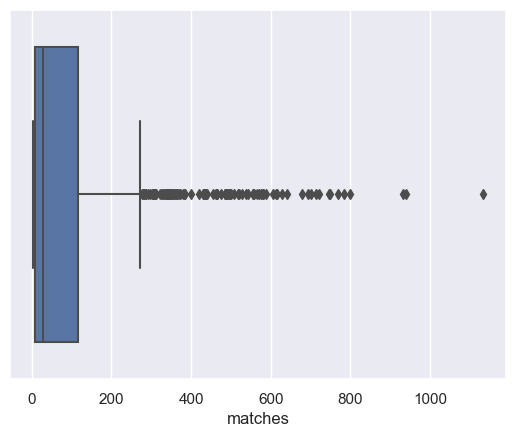

In [32]:
sns.boxplot(x='matches', data=win_loss);

##### Le nombre de matchs joués varie fortement. Divisons les données sur la base du nombre de matchs joués

In [33]:
labels = ['Very irregular player', 'Irregular player', 'Regular player', 'Very regular player']
win_loss['cat_match'] = pd.cut(x=win_loss.matches, bins=4, labels=labels)
win_loss.head()

,Winner,Loser,w_per_match,matches,cat_match
Federer R.,945,189,0.833,1134,Very regular player
Djokovic N.,664,135,0.831,799,Regular player
Nadal R.,777,163,0.827,940,Very regular player
Nargiso D.,8,2,0.800,10,Very irregular player
Murray A.,541,159,0.773,700,Regular player


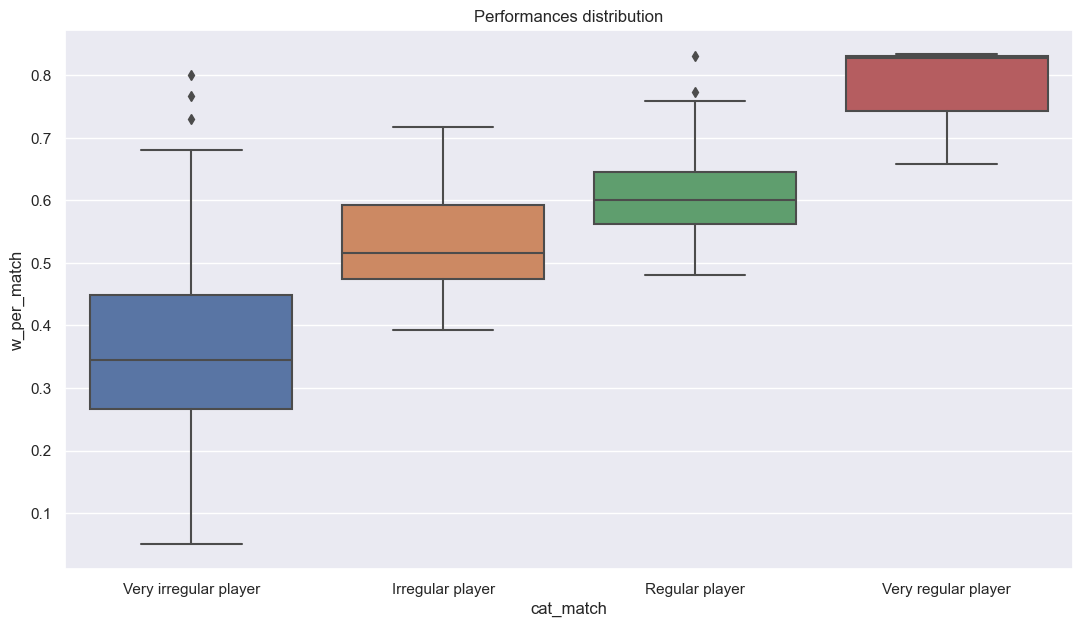

In [34]:
plt.figure(figsize=(13,7))
sns.boxplot(x='cat_match', y='w_per_match', data=win_loss)
plt.title('Performances distribution');

##### Plus on joue de matchs plus la performance est bonne. Plus on joue, plus on a de chances de gagner. Le graphique les conclusions du test de pearson.

C:\Users\00080609\AppData\Local\Temp\ipykernel_10132\4028196650.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.title('Top 20 performance'); plt.grid(b=True);
C:\Users\00080609\AppData\Local\Temp\ipykernel_10132\4028196650.py:18: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.title('Flop 20 performance'); plt.grid(b=True);


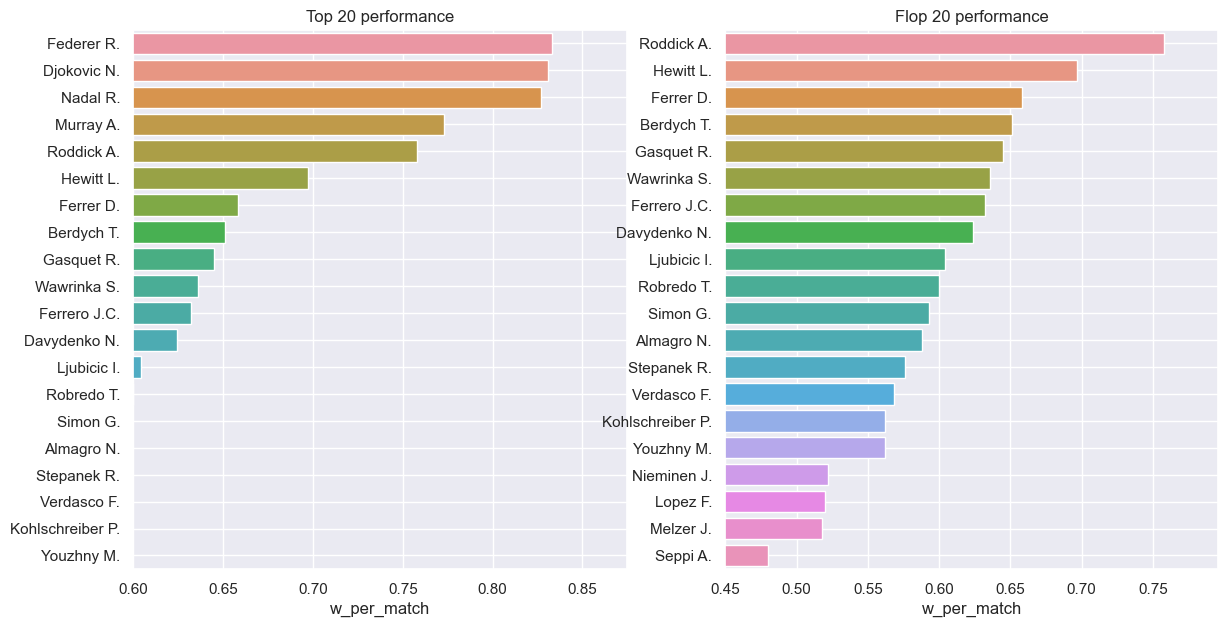

In [35]:
# Performance de ceux qui ont joué plus de 157 matches (le dernier quantiles)

# Top 20 performces

plt.figure(figsize=(14,7))

plt.subplot(121)
data = win_loss.loc[win_loss.cat_match >= 'Regular player'].head(20)
x, y = data.w_per_match, data.index
sns.barplot(x=x, y=y, data=data, order = y, orient='h'); plt.xlim((0.6, None));
plt.title('Top 20 performance'); plt.grid(b=True);

# Flop 20
plt.subplot(122)
data = win_loss.loc[win_loss.cat_match >= 'Regular player'].tail(20)
x, y = data.w_per_match, data.index
sns.barplot(x=x, y=y, data=data, order=y, orient='h'); plt.xlim((0.45, None)); 
plt.title('Flop 20 performance'); plt.grid(b=True);

##### Les joueurs ayant joués plus 157 matchs gagnent plus de 60% de leurs matches.

#### Existe-t-il une correlation entre la performance et le type de tournoi joué ? Procédons par un test statistique : test ANOVA

### 2.3. Performances en fonction des Series

In [36]:
# Création du dataFrame
winner_tampon = pd.DataFrame(df1[['Winner', 'Series']].value_counts()).reset_index()
winner_tampon.rename({'Winner' : 'Player', 0: 'Winner'}, inplace=True, axis=1)
#winner_tampon.set_index('Player', inplace=True)

loser_tampon = pd.DataFrame(df1[['Loser', 'Series']].value_counts()).reset_index()
loser_tampon.rename({'Loser' : 'Player', 0: 'Loser'}, inplace=True, axis=1)
#loser_tampon.set_index('Player', inplace=True)

win_loss_ser = winner_tampon.merge(right=loser_tampon, on=['Player','Series'], how='right')

win_loss_ser

,Player,Series,Winner,Loser
0,Garcia-Lopez G.,ATP250,106.0,92
1,Istomin D.,ATP250,85.0,90
2,Martin A.,International,71.0,85
3,Spadea V.,International,92.0,84
4,Rochus C.,International,53.0,81
...,...,...,...,...
3827,Lokoli L.,ATP250,NaN,1
3828,Lojda D.,Grand Slam,NaN,1
3829,Lisnard J.,Masters,1.0,1
3830,Lipsky S.,International,NaN,1


In [37]:
# les NA correspondent ici à des 0

win_loss_ser = win_loss_ser.fillna(0)

In [38]:
win_loss_ser['matches'] = win_loss_ser.Winner + win_loss_ser.Loser
win_loss_ser['w_per_match'] = round(win_loss_ser.Winner / win_loss_ser.matches,3)

win_loss_ser.sort_values(by = ['w_per_match', 'Series'], ascending=False, inplace=True)
win_loss_ser.set_index('Player', inplace=True)

##### H0 : La performance et le type de tournoi sont indépendantes

In [39]:
import statsmodels.api

result = statsmodels.formula.api.ols('w_per_match ~ Series', data=win_loss_ser).fit()
table = statsmodels.api.stats.anova_lm(result)

table

,df,sum_sq,mean_sq,F,PR(>F)
Series,7.0,1.161460,0.165923,3.095146,0.002954
Residual,3824.0,204.994887,0.053607,NaN,NaN


##### La p-value (PR(>F)) est < 5%, on rejette donc l'hypothèse nulle

In [40]:
labels = ['Very irregular player', 'Irregular player', 'Regular player', 'Very regular player']
win_loss_ser['cat_match'] = pd.cut(x=win_loss_ser.matches, bins=4, labels=labels)

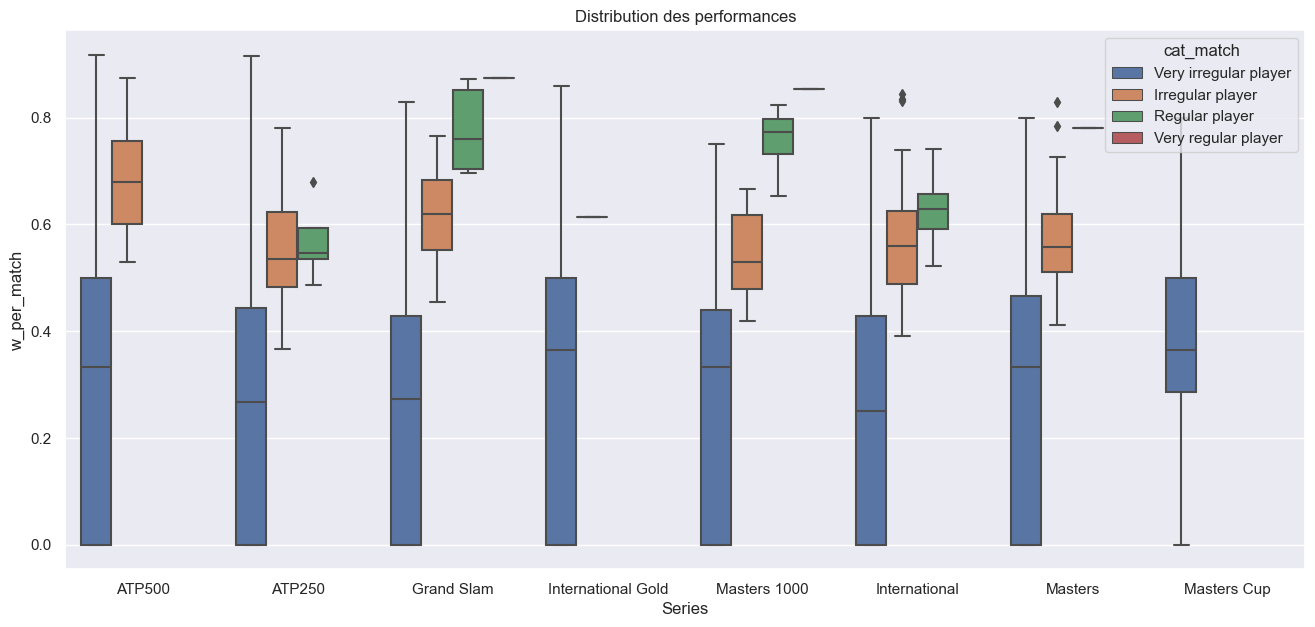

In [41]:
# Vérification graphique

plt.figure(figsize=(16,7))
sns.boxplot(data=win_loss_ser, x='Series', y='w_per_match', hue='cat_match')
plt.title('Distribution des performances');

##### Performance des meilleurs joueurs 

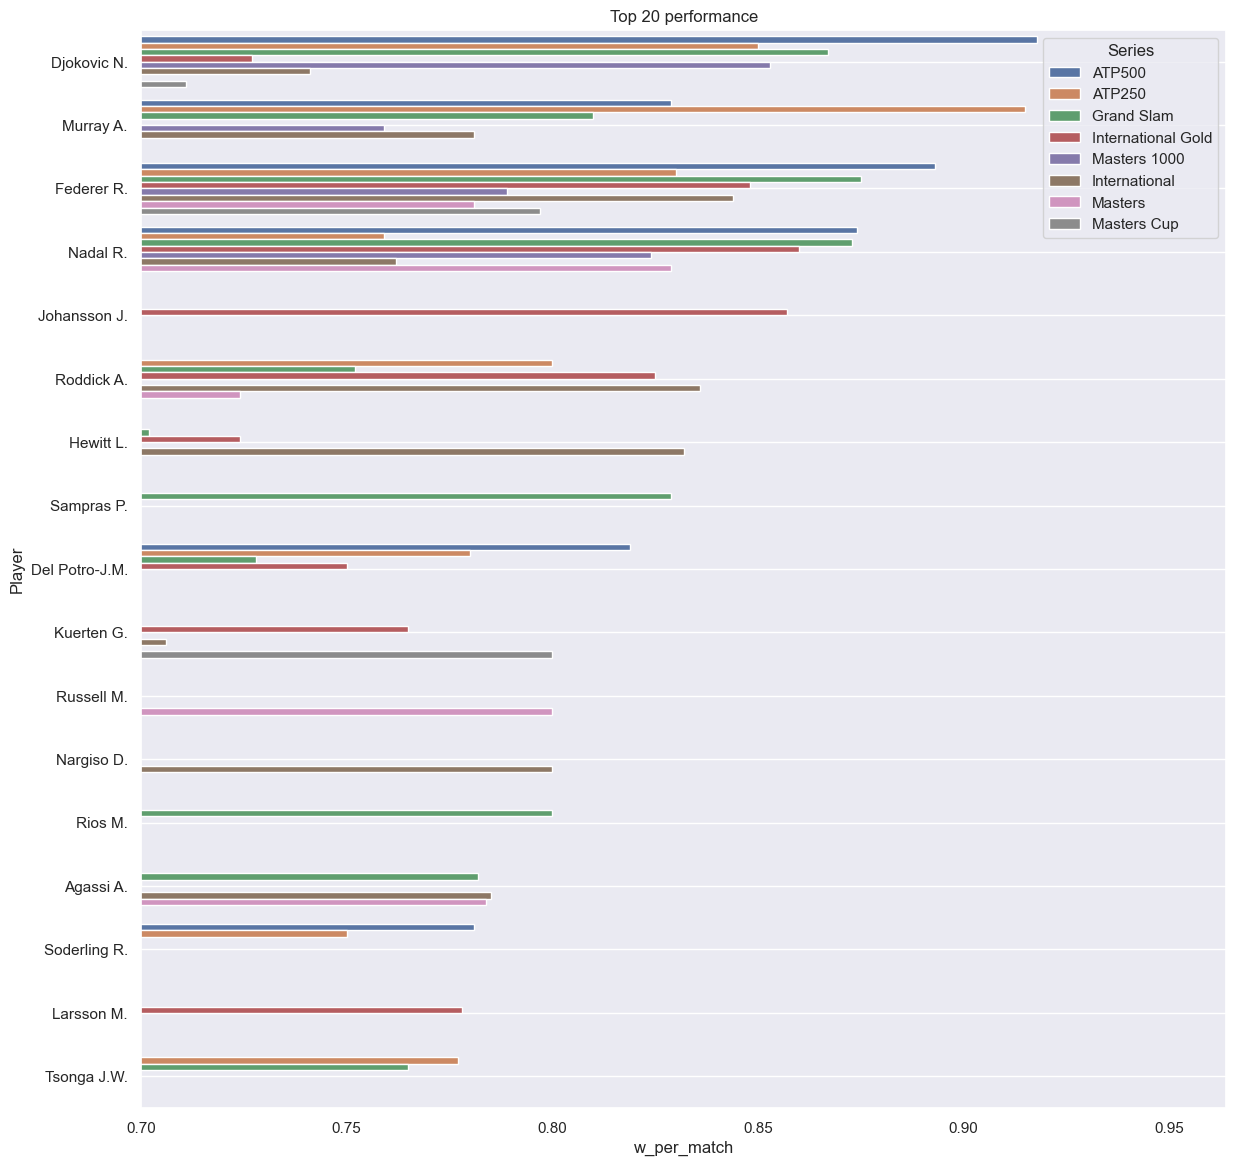

In [42]:
# Top 20 performces

plt.figure(figsize=(14,14))

y_uniq = win_loss_ser.head(40).index.unique()

data = win_loss_ser.loc[win_loss_ser.index.isin(y_uniq)]
x, y = data.w_per_match, data.index
sns.barplot(x=x, y=y, data=data, hue='Series', orient='h'); plt.xlim((0.7, None));
plt.title('Top 20 performance'); plt.grid();

##### Existe-t-il une correlation entre la performance et le type de court ? 
##### Procédons par un test statistique : test ANOVA

### 2.3. Performances en fonction du type de court

In [43]:
# Création du dataFrame
winner_tampon = pd.DataFrame(df1[['Winner', 'Court']].value_counts()).reset_index()
winner_tampon.rename({'Winner' : 'Player', 0: 'Winner'}, inplace=True, axis=1)

loser_tampon = pd.DataFrame(df1[['Loser', 'Court']].value_counts()).reset_index()
loser_tampon.rename({'Loser' : 'Player', 0: 'Loser'}, inplace=True, axis=1)

win_loss_cou = winner_tampon.merge(right=loser_tampon, on=['Player','Court'], how='right')

win_loss_cou

,Player,Court,Winner,Loser
0,Lopez F.,Outdoor,318.0,282
1,Verdasco F.,Outdoor,378.0,275
2,Youzhny M.,Outdoor,301.0,260
3,Ferrer D.,Outdoor,530.0,257
4,Garcia-Lopez G.,Outdoor,206.0,241
...,...,...,...,...
1988,Massa E.,Indoor,NaN,1
1989,Masur D.,Indoor,NaN,1
1990,Masur D.,Outdoor,NaN,1
1991,Mathieu P.,Indoor,NaN,1


In [44]:
# les NA correspondent ici à des 0

win_loss_cou = win_loss_cou.fillna(0)

In [45]:
win_loss_cou['matches'] = win_loss_cou.Winner + win_loss_cou.Loser
win_loss_cou['w_per_match'] = round(win_loss_cou.Winner / win_loss_cou.matches,3)

win_loss_cou.sort_values(by = ['w_per_match', 'Player', 'Court'], ascending=False, inplace=True)
win_loss_cou

,Player,Court,Winner,Loser,matches,w_per_match
120,Djokovic N.,Outdoor,571.0,101,672.0,0.850
77,Nadal R.,Outdoor,712.0,130,842.0,0.846
56,Federer R.,Outdoor,744.0,145,889.0,0.837
301,Federer R.,Indoor,201.0,44,245.0,0.820
1652,Jarry N.,Indoor,4.0,1,5.0,0.800
...,...,...,...,...,...,...
1718,Agostinelli B.,Outdoor,0.0,1,1.0,0.000
1236,Ager J.,Outdoor,0.0,2,2.0,0.000
1717,Agaev E.,Outdoor,0.0,1,1.0,0.000
1716,Adaktusson J.,Outdoor,0.0,1,1.0,0.000


##### H0 : La performance et le type de tournoi sont indépendantes

In [46]:
import statsmodels.api

result = statsmodels.formula.api.ols('w_per_match ~ Court', data=win_loss_cou).fit()
table = statsmodels.api.stats.anova_lm(result)

table

,df,sum_sq,mean_sq,F,PR(>F)
Court,1.0,0.633924,0.633924,12.768182,0.000361
Residual,1991.0,98.850551,0.049649,NaN,NaN


##### La p-value (PR(>F)) est < 5%, on rejette donc l'hypothèse nulle

In [47]:
win_loss_cou['cat_match'] = pd.cut(x=win_loss_cou.matches, bins=4, labels=labels)

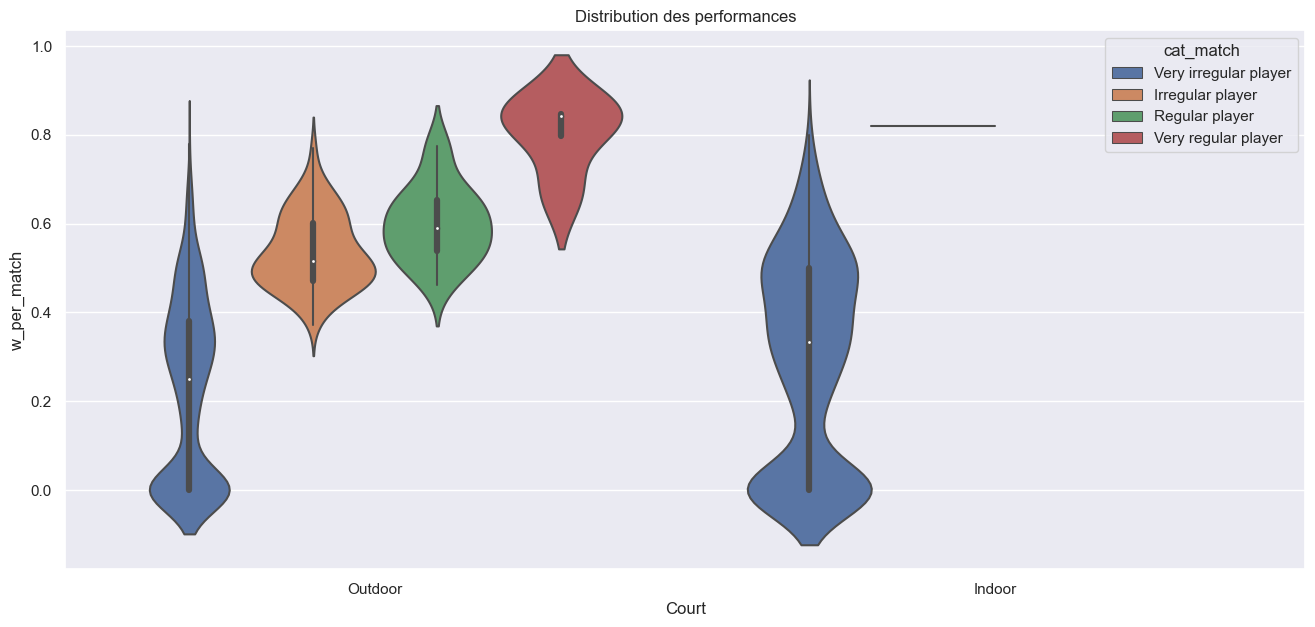

In [48]:
# Vérification graphique

plt.figure(figsize=(16,7))
sns.violinplot(data=win_loss_cou, x='Court', y='w_per_match', hue='cat_match')
plt.title('Distribution des performances');

##### Le graphique confirme le test statistique

##### Performance des meilleurs joueurs

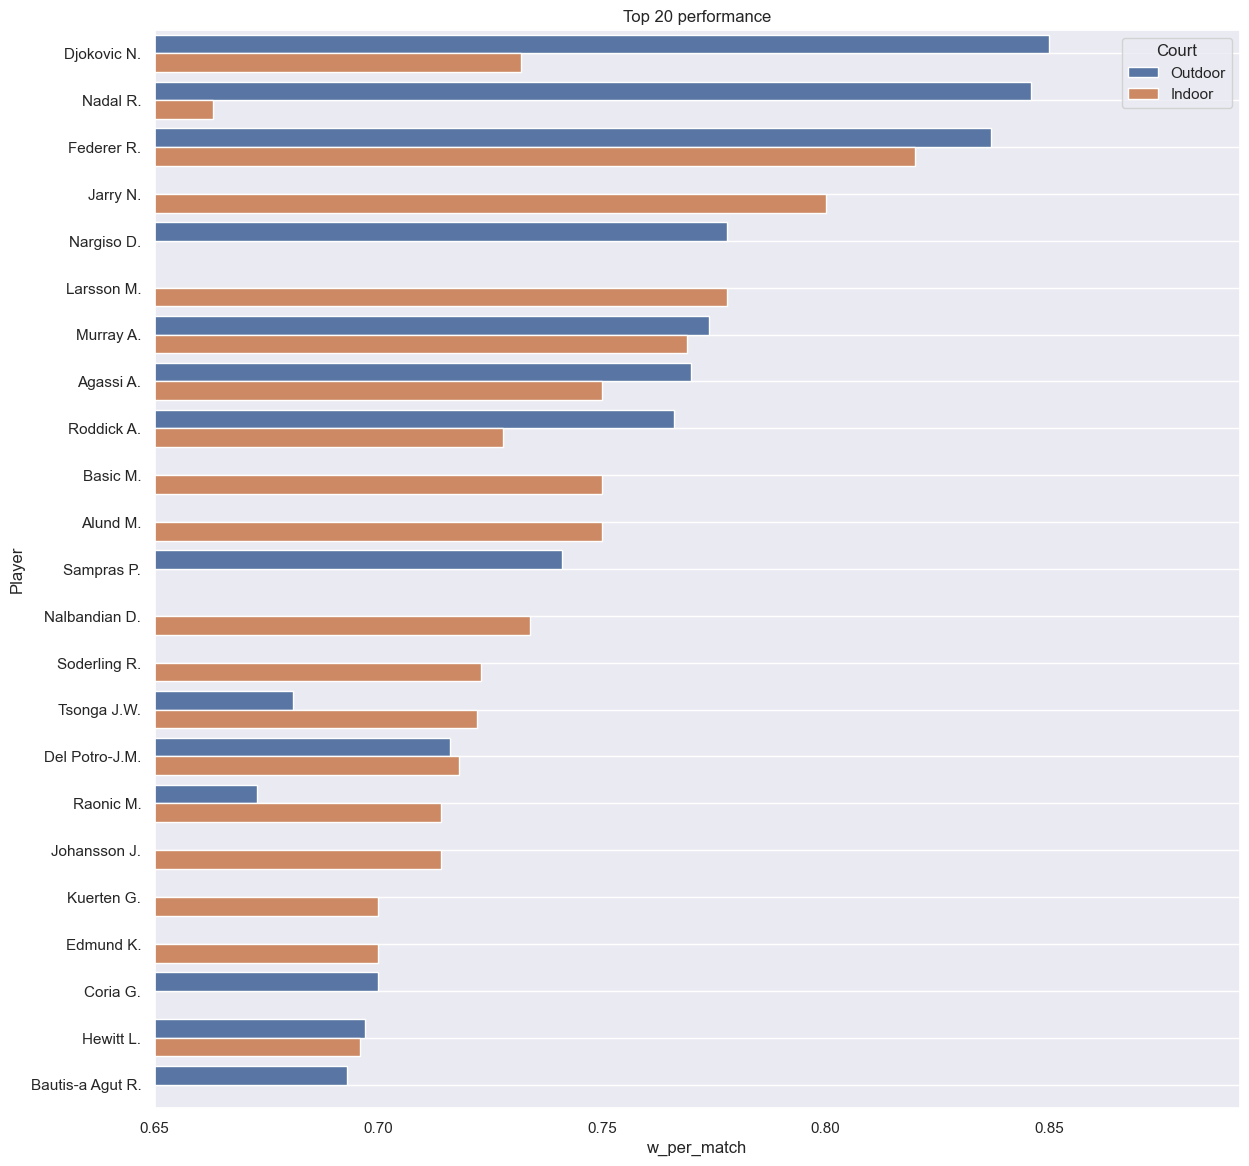

In [49]:
# Top 20 performces

plt.figure(figsize=(14,14))

y_uniq = win_loss_cou.head(30).Player.unique()

data = win_loss_cou.loc[win_loss_cou.Player.isin(y_uniq)]
x, y = data.w_per_match, data.Player
sns.barplot(x=x, y=y, data=data, hue='Court', orient='h'); plt.xlim((0.65, None));
plt.title('Top 20 performance'); plt.grid();

##### Existe-t-il une correlation entre la performance et le type de surface ? 
##### Procédons par un test statistique : test ANOVA

### 2.4. Performances en fonction du type de surface

,Player,Surface,Winner,Loser,matches,w_per_match
392,Nadal R.,Clay,340.0,31,371.0,0.916
666,Federer R.,Grass,137.0,17,154.0,0.890
1917,Rafter P.,Grass,12.0,2,14.0,0.857
123,Djokovic N.,Hard,435.0,80,515.0,0.845
57,Federer R.,Hard,589.0,110,699.0,0.843


,df,sum_sq,mean_sq,F,PR(>F)
Surface,3.0,1.755389,0.585130,11.116294,2.976309e-07
Residual,2871.0,151.121189,0.052637,NaN,NaN


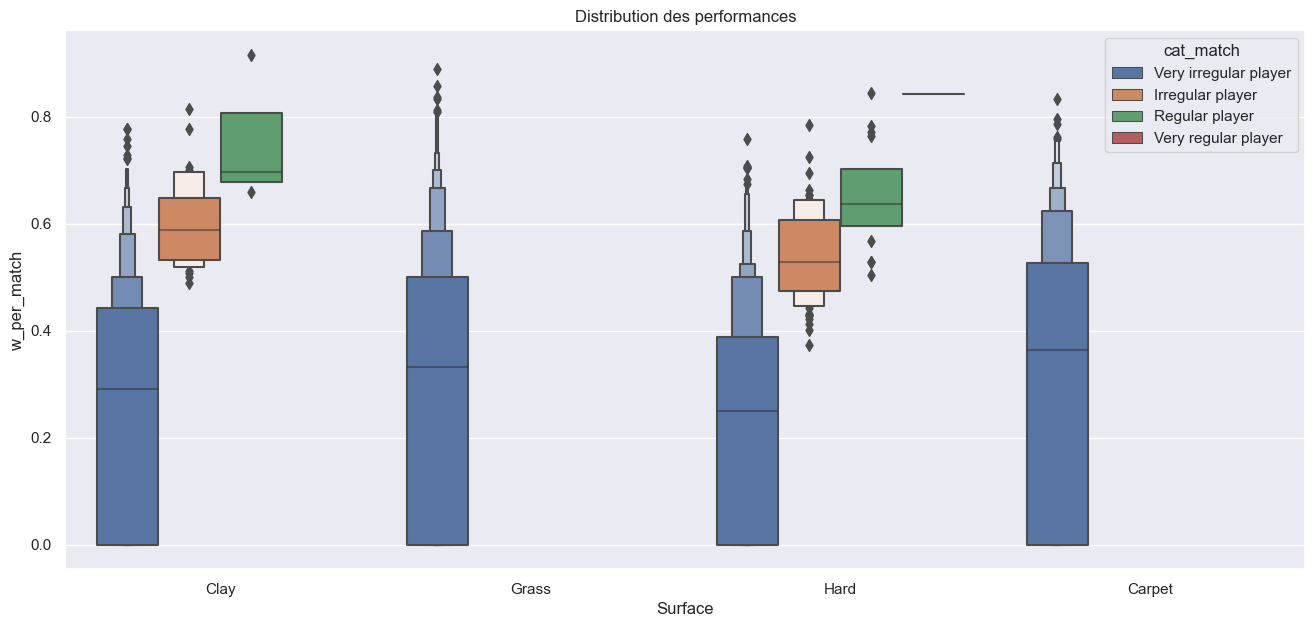

In [50]:
# Création du dataFrame

winner_tampon = pd.DataFrame(df1[['Winner', 'Surface']].value_counts()).reset_index()
winner_tampon.rename({'Winner' : 'Player', 0: 'Winner'}, inplace=True, axis=1)

loser_tampon = pd.DataFrame(df1[['Loser', 'Surface']].value_counts()).reset_index()
loser_tampon.rename({'Loser' : 'Player', 0: 'Loser'}, inplace=True, axis=1)

win_loss_sur = winner_tampon.merge(right=loser_tampon, on=['Player','Surface'], how='right')

# les NA correspondent ici à des 0

win_loss_sur = win_loss_sur.fillna(0)

win_loss_sur['matches'] = win_loss_sur.Winner + win_loss_sur.Loser
win_loss_sur['w_per_match'] = round(win_loss_sur.Winner / win_loss_sur.matches,3)

win_loss_sur.sort_values(by = ['w_per_match', 'Player', 'Surface'], ascending=False, inplace=True)
display(win_loss_sur.head())

# H0 : La performance et le type de tournoi sont indépendantes

import statsmodels.api

result = statsmodels.formula.api.ols('w_per_match ~ Surface', data=win_loss_sur).fit()
table = statsmodels.api.stats.anova_lm(result)

display(table)

# La p-value (PR(>F)) est < 5%, on rejette donc l'hypothèse nulle

win_loss_sur['cat_match'] = pd.cut(x=win_loss_sur.matches, bins=4, labels=labels)

# Vérification graphique

plt.figure(figsize=(16,7))
sns.boxenplot(x=win_loss_sur.Surface, y=win_loss_sur.w_per_match, hue=win_loss_sur['cat_match'])
plt.title('Distribution des performances');

# Le graphique confirme le test statistique

##### Performance des meilleurs joueurs

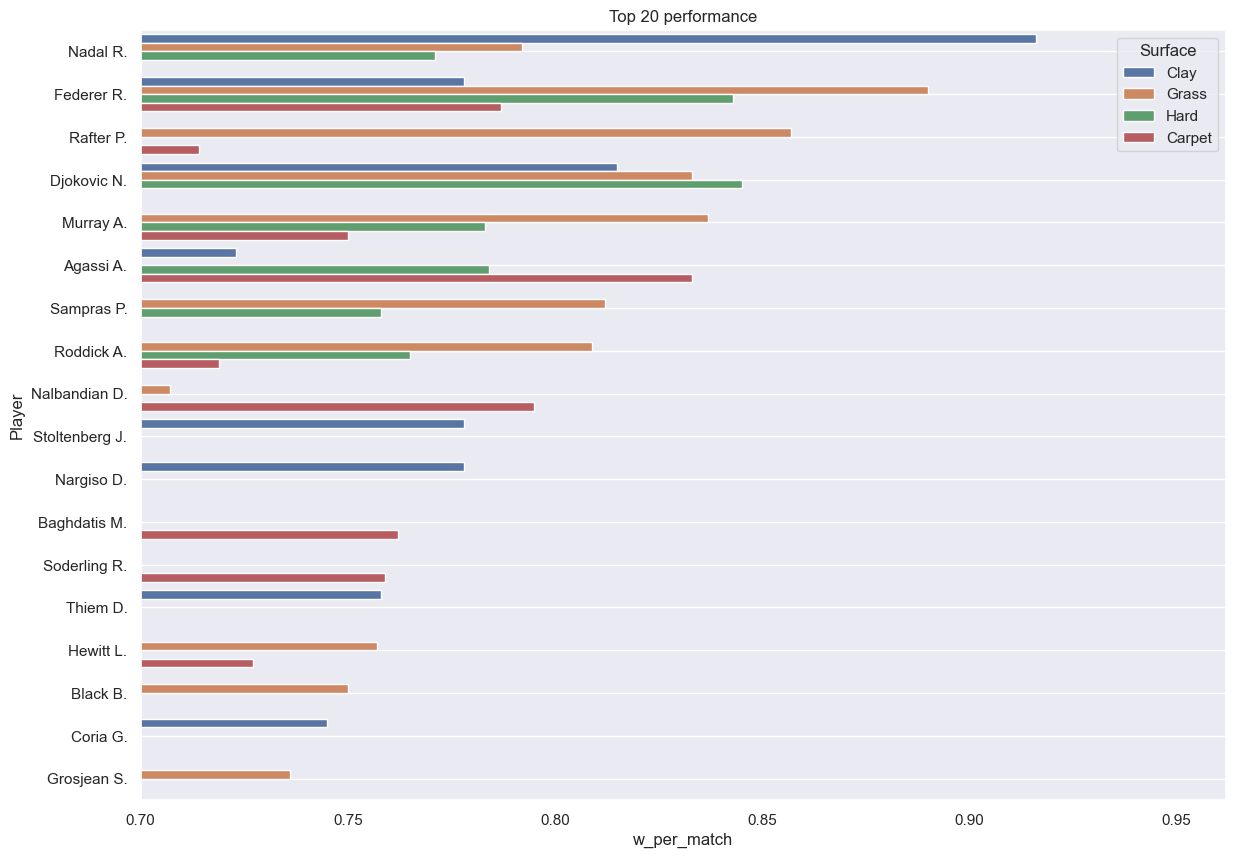

In [51]:
# Top 20 performces

plt.figure(figsize=(14,10))

y_uniq = win_loss_sur.head(30).Player.unique()

data = win_loss_sur.loc[win_loss_sur.Player.isin(y_uniq)]
x, y = data.w_per_match, data.Player
sns.barplot(x=x, y=y, data=data, hue='Surface', orient='h'); plt.xlim((0.7, None));
plt.title('Top 20 performance'); plt.grid();

##### Mis à part Federer qui semble être le joueur le plus polyvalent, on constate que la surface influe fortement sur la performance. 
##### Nadal en est l'exemple le plus criard. Il gagne presque 93% de ses matchs sur terre battue, mais ne gagne que 77% des matchs sur 'Hard'. Soit environ 16 points de delta.

### 2.5. La hiérarchie des classements est-elle toujours respectée ?

#### Proportion des matches gagnés par Outsider

In [52]:
outsider_tampon = pd.DataFrame(df1.loc[df1.WRank > df1.LRank, ['Series', 'Court', 'Surface']].value_counts(), 
                               columns=['outsider_win'])
challenger_tampon = pd.DataFrame(df1.loc[-(df1.WRank > df1.LRank), ['Series', 'Court', 'Surface']].value_counts(), 
                                 columns=['challenger_win'])
cha_out = challenger_tampon.join(outsider_tampon)
cha_out.head()

,,,challenger_win,outsider_win
Series,Court,Surface,,
Grand Slam,Outdoor,Hard,2918,1074
International,Outdoor,Clay,2472,1355
ATP250,Outdoor,Clay,1996,1149
Masters 1000,Outdoor,Hard,1808,900
International,Outdoor,Hard,1778,935


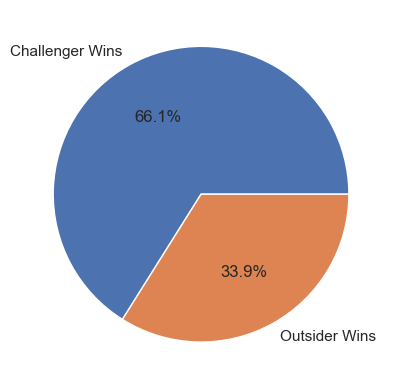

In [53]:
#plt.figure(figsize=(9,6))
sizes=[cha_out.challenger_win.sum(), cha_out.outsider_win.sum()]
plt.pie(sizes,labels=['Challenger Wins', 'Outsider Wins'], autopct="%.1f%%")#, normalize=True)
plt.show()

##### We observe that Challengers win approximately twice more than Outsiders

### 2.6 Bookmakers performance

In [54]:
df1.iloc[:,7:].head()

,Round,Best of,Winner,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
0,1st Round,3,Dosedel S.,Ljubicic I.,63,77,2,0,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5
1,1st Round,3,Kiefer N.,Tarango J.,6,59,2,0,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5
2,1st Round,3,Gaudio G.,Luxa P.,73,174,2,1,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5
3,1st Round,3,El Aynaou- Y.,Dupuis A.,33,78,2,1,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5
4,1st Round,3,Cherkasov A.,Arazi H.,206,35,2,0,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5


In [55]:
# 3 possibilities : win for challenger, loss for challenger or draw

In [56]:
atp_challenger_win, atp_outsider_win, atp_draw = len(df1[df1.WRank < df1.LRank]), len(df1[df1.WRank > df1.LRank]), len(df1[df1.WRank == df1.LRank])

ps_challenger_win, ps_outsider_win, ps_draw = len(df1[df1.PSW < df1.PSL]), len(df1[df1.PSW > df1.PSL]), len(df1[(df1.PSW == df1.PSL) & (df1.PSW != 1)])

b365_challenger_win, b365_outsider_win, b365_draw = len(df1[df1.B365W < df1.B365L]), len(df1[df1.B365W > df1.B365L]), len(df1[(df1.B365W == df1.B365L) & (df1.B365W != 1)])

elo_challenger_win, elo_outsider_win, elo_draw = len(df1[df1.proba_elo > 0.5]), len(df1[df1.proba_elo < 0.5]), len(df1[df1.proba_elo == 0.5])

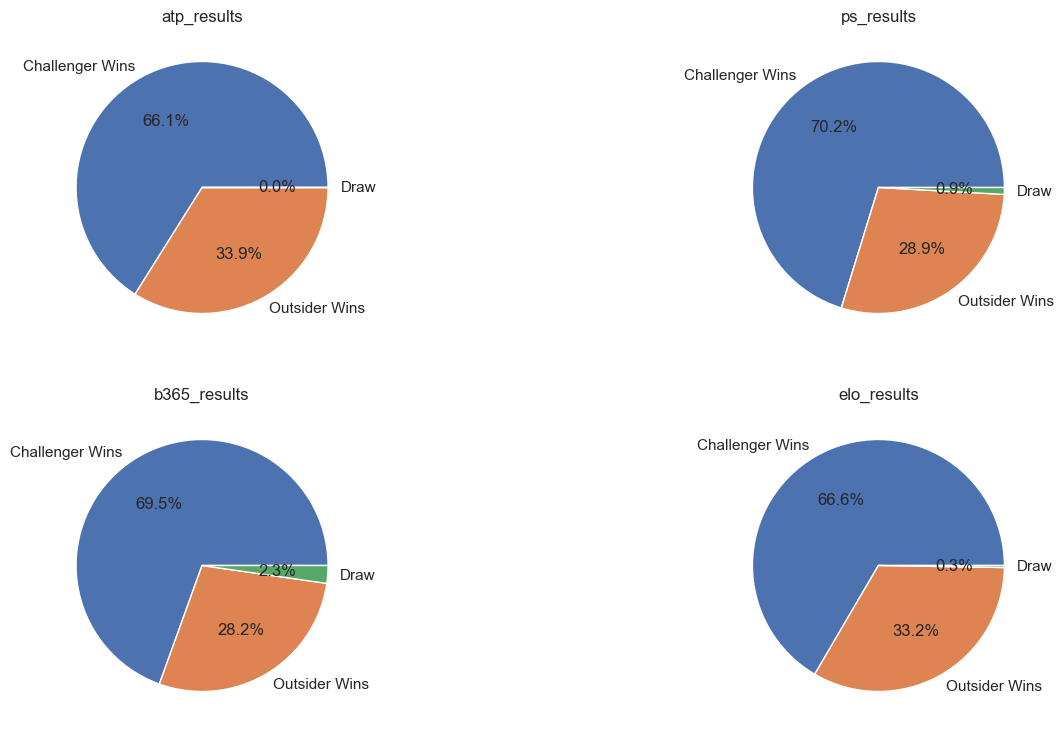

In [57]:
atp_results = [atp_challenger_win, atp_outsider_win, atp_draw]
ps_results = [ps_challenger_win, ps_outsider_win, ps_draw]
b365_results = [b365_challenger_win, b365_outsider_win, b365_draw]
elo_results = [elo_challenger_win, elo_outsider_win, elo_draw]

pie_charts = [atp_results, ps_results, b365_results, elo_results]
fig = plt.figure(figsize=(16,9))

ax1 = fig.add_subplot(221)
ax1.pie(pie_charts[0], labels=['Challenger Wins', 'Outsider Wins', 'Draw'], autopct="%.1f%%")#, normalize=True)
ax1.set_title('atp_results')

ax2 = fig.add_subplot(222)
ax2.pie(pie_charts[1], labels=['Challenger Wins', 'Outsider Wins', 'Draw'], autopct="%.1f%%")#, normalize=True)
ax2.set_title('ps_results')

ax3 = fig.add_subplot(223)
ax3.pie(pie_charts[2], labels=['Challenger Wins', 'Outsider Wins', 'Draw'], autopct="%.1f%%")#, normalize=True)
ax3.set_title('b365_results')

ax4 = fig.add_subplot(224)
ax4.pie(pie_charts[3], labels=['Challenger Wins', 'Outsider Wins', 'Draw'], autopct="%.1f%%")#, normalize=True)
ax4.set_title('elo_results')
plt.show();

In [58]:
# Bookmakers (B365 and PS) are right 70% of time. 

###### Do bookmakers always have the outsider and challenger ? 

In [59]:
len(df1[(df1.PSW < df1.PSL) & (df1.B365W > df1.B365L)]) / len(df1) * 100

0.4579904217231599

In [60]:
# Yes they do.

# 3. Predictions - Model

### 3.1 Data preprocessing / Features engineering

In [61]:
# Lets change the dataset structure

In [62]:
display(df1.iloc[:,:10].head())
df1.iloc[:,10:25].head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Kiefer N.
2,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Gaudio G.
3,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,El Aynaou- Y.
4,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Cherkasov A.


,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
0,Ljubicic I.,63,77,2,0,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5
1,Tarango J.,6,59,2,0,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5
2,Luxa P.,73,174,2,1,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5
3,Dupuis A.,33,78,2,1,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5
4,Arazi H.,206,35,2,0,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5


In [63]:
df2 = df1.copy()

df2['player1'] = df2.Winner.copy()
df2['player2'] = df2.Loser.copy()
df2.drop('Loser', axis=1, inplace=True)
df2.rename({'Winner': 'player1_wins', 'WRank': 'rank1', 'LRank': 'rank2', 'Wsets': 'sets1', 'Lsets': 'sets2',
            'PSW': 'ps1', 'PSL': 'ps2', 'B365W': 'b365_1', 'B365L': 'b365_2', 'elo_winner': 'elo1', 
            'elo_loser': 'elo2', 'Date':'date'}, axis=1, inplace=True)

df3 = df2.copy()

df2.loc[:,'player1_wins'], df3.loc[:,'player1_wins'] = -1, 1

df2.player1, df2.player2 = df3.player2, df3.player1
df2.rank1, df2.rank2 = df3.rank2, df3.rank1
df2.sets1, df2.sets2 = df3.sets2, df3.sets1
df2.ps1, df2.ps2 = df3.ps2, df3.ps1
df2.b365_1, df2.b365_2 = df3.b365_2, df3.b365_1
df2.elo1, df2.elo2 = df3.elo2, df3.elo1

df2 = df2.append(df3, ignore_index=True)
del df3

display(df2.iloc[:,:10].head())
df2.iloc[:,10:].head()

C:\Users\00080609\AppData\Local\Temp\ipykernel_10132\1361140109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(df3, ignore_index=True)


,ATP,Location,Tournament,date,Series,Court,Surface,Round,Best of,player1_wins
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,-1
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,-1
2,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,-1
3,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,-1
4,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,-1


,rank1,rank2,sets1,sets2,Comment,ps1,ps2,b365_1,b365_2,elo1,elo2,proba_elo,player1,player2
0,77,63,0,2,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5,Ljubicic I.,Dosedel S.
1,59,6,0,2,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5,Tarango J.,Kiefer N.
2,174,73,1,2,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5,Luxa P.,Gaudio G.
3,78,33,1,2,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5,Dupuis A.,El Aynaou- Y.
4,35,206,0,2,Completed,1.0,1.0,1.0,1.0,1500.0,1500.0,0.5,Arazi H.,Cherkasov A.


In [64]:
col_prev_match = []
'''for j in range(1,4):
    col_prev_match.append('player1_wins_m-'+str(j))
    df2[['player1_wins_m-'+str(j)]] = np.nan

    for i in df2.player1.unique():
        df_one_player = df2.loc[df2.player1 == i].sort_values(by='date', ascending=False).shift(-j)
        df2.loc[df2.index.isin(df_one_player.index) == True, 'player1_wins_m-'+str(j)] = \
            df_one_player.loc[df_one_player.index.isin(df2.index) == True, 'player1_wins']

    df2['player1_wins_m-'+str(j)].fillna(0, axis=0, inplace=True)'''

"for j in range(1,4):\n    col_prev_match.append('player1_wins_m-'+str(j))\n    df2[['player1_wins_m-'+str(j)]] = np.nan\n\n    for i in df2.player1.unique():\n        df_one_player = df2.loc[df2.player1 == i].sort_values(by='date', ascending=False).shift(-j)\n        df2.loc[df2.index.isin(df_one_player.index) == True, 'player1_wins_m-'+str(j)] =             df_one_player.loc[df_one_player.index.isin(df2.index) == True, 'player1_wins']\n\n    df2['player1_wins_m-'+str(j)].fillna(0, axis=0, inplace=True)"

In [65]:
col_to_keep = col_prev_match + ['Tournament', 'Round', 'player1_wins', 'rank1', 'rank2', 'ps1', 'ps2', 'b365_1', 'b365_2',
               'elo1', 'elo2', 'player1', 'player2']
df_final = df2[col_to_keep]

In [66]:
df_final.iloc[30:40,:]

,Tournament,Round,player1_wins,rank1,rank2,ps1,ps2,b365_1,b365_2,elo1,elo2,player1,player2
30,Qatar Open,2nd Round,-1,39,47,1.0,1.0,1.0,1.0,1500.0,1518.808638,Vacek D.,Schuettler R.
31,Gold Flake Open,2nd Round,-1,111,162,1.0,1.0,1.0,1.0,1500.0,1484.736307,Stanoytchev O.,Delgado J.
32,Qatar Open,2nd Round,-1,49,44,1.0,1.0,1.0,1.0,1500.0,1499.295977,Squillari F.,Schalken S.
33,Qatar Open,2nd Round,-1,71,74,1.0,1.0,1.0,1.0,1516.0,1499.363541,Marin J.A.,Mirnyi M.
34,Qatar Open,2nd Round,-1,211,6,1.0,1.0,1.0,1.0,1516.0,1517.406490,Caratti C.,Kiefer N.
35,Qatar Open,2nd Round,-1,73,33,1.0,1.0,1.0,1.0,1516.0,1514.630251,Gaudio G.,El Aynaou- Y.
36,Qatar Open,2nd Round,-1,60,85,1.0,1.0,1.0,1.0,1516.0,1501.403778,Berasategui A.,Bastl G.
37,Qatar Open,1st Round,-1,50,39,1.0,1.0,1.0,1.0,1500.0,1484.865325,Vicente F.,Vacek D.
38,Qatar Open,1st Round,-1,62,83,1.0,1.0,1.0,1.0,1500.0,1501.406397,Ivanisevic G.,Tillstrom M.
39,Qatar Open,1st Round,-1,93,49,1.0,1.0,1.0,1.0,1500.0,1483.967579,Siemerink J.,Squillari F.


In [67]:
#df2.loc[df2.player1 == 'Luxa P.'].sort_values(by='date', ascending=False).iloc[:,[3,9,10,25,26,34,35]]

In [68]:
data = df_final.drop(['player1_wins'], axis=1)
target = df_final.player1_wins

In [69]:
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=.7)

In [70]:
X_train_num, X_test_num = X_train.select_dtypes(include=np.number), X_test.select_dtypes(include=np.number)
X_train_cat1, X_test_cat1 = X_train[['Round']], X_test[['Round']]
X_train_cat2, X_test_cat2 = X_train[['Tournament', 'player1', 'player2']], X_test[['Tournament', 'player1', 'player2']]

In [71]:
# We standardize numerical values :
scaler = StandardScaler()
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), index=X_train.index, columns = X_train_num.columns)
X_test_num_scaled = pd.DataFrame(scaler.transform(X_test_num), index=X_test.index, columns = X_test_num.columns)

In [72]:
# We encode our categorical values :
oneh = OneHotEncoder(handle_unknown = 'ignore')

X_train_cat_encod1 = pd.DataFrame(oneh.fit_transform(X_train_cat1).toarray(), index=X_train.index, columns = oneh.get_feature_names())
X_test_cat_encod1 = pd.DataFrame(oneh.transform(X_test_cat1).toarray(), index=X_test.index, columns = oneh.get_feature_names())

In [73]:
# We encode our categorical values :
le1 = LabelEncoder()
le2 = LabelEncoder()

le2.fit(data.loc[:,'player1'].append(data.loc[:,'player2'], ignore_index=True).drop_duplicates())

X_train_cat_encod2 = pd.DataFrame({X_train_cat2.columns[0] : le1.fit_transform(X_train_cat2.iloc[:,0]),
                                   X_train_cat2.columns[1] : le2.transform(X_train_cat2.iloc[:,1]),
                                   X_train_cat2.columns[2] : le2.transform(X_train_cat2.iloc[:,2])}, index=X_train.index)
X_test_cat_encod2 = pd.DataFrame({X_test_cat2.columns[0] : le1.fit_transform(X_test_cat2.iloc[:,0]),
                                   X_test_cat2.columns[1] : le2.transform(X_test_cat2.iloc[:,1]),
                                   X_test_cat2.columns[2] : le2.transform(X_test_cat2.iloc[:,2])}, index=X_test.index)

C:\Users\00080609\AppData\Local\Temp\ipykernel_10132\1380154253.py:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  le2.fit(data.loc[:,'player1'].append(data.loc[:,'player2'], ignore_index=True).drop_duplicates())


In [74]:
X_train = pd.concat([X_train_cat_encod1, X_train_cat_encod2, X_train_num_scaled], axis=1)
X_test = pd.concat([X_test_cat_encod1, X_test_cat_encod2, X_test_num_scaled], axis=1)

In [75]:
#!conda install -c conda-forge py-xgboost
#!pip install --user xgboost

### 3.2 Model selection

In [109]:
# Model definition
lr = LogisticRegression()
knn = KNeighborsClassifier(2)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
ac = AdaBoostClassifier()

xg = xgboost.XGBClassifier()
xg.fit(X_train, y_train.replace({-1:0}))
xg.score(X_test, y_test.replace({-1:0}))

# Model training
lr.fit(X_train, y_train)
print("score du lr : {}".format(lr.score(X_test, y_test)))

dt.fit(X_train, y_train)
print("score du dt : {}".format(dt.score(X_test, y_test)))

ac.fit(X_train, y_train)
print("score du ac : {}".format(ac.score(X_test, y_test)))

knn.fit(X_train, y_train)
print("score du knn : {}".format(knn.score(X_test, y_test)))

rf.fit(X_train, y_train)
print("score du rf : {}".format(rf.score(X_test, y_test)))

xg.fit(X_train, y_train.replace({-1:0}))
print("score du xg : {}".format(xg.score(X_test, y_test.replace({-1:0}))) )

C:\Users\00080609\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


score du lr : 0.6947188965089698
score du dt : 0.6075787515982797
score du ac : 0.694641404161339
score du knn : 0.5267929791933047
score du rf : 0.6831337905381843
score du xg : 0.6899531171296834


In [77]:
# Model prediction
y_pred_lr = lr.predict(X_test) 

# Classification report
print(classification_report(y_test, y_pred_lr))

# Correlation matrix
pd.crosstab(y_test, y_pred_lr, rownames=['Real class'], colnames=['lr prediction class'])

              precision    recall  f1-score   support

          -1       0.70      0.69      0.70     13089
           1       0.69      0.70      0.69     12720

    accuracy                           0.69     25809
   macro avg       0.69      0.69      0.69     25809
weighted avg       0.69      0.69      0.69     25809



lr prediction class,-1,1
Real class,,
-1,9020,4069
1,3819,8901


In [78]:
# Our models struggle to overperform the bookmakers predictions.
# As reminder, bookmakers hs a score close to 70%.
# We must improve our model

### 3.3 Hyperparameters tunning : Nested Cross-Validation

In [99]:
# Model definition
lr = LogisticRegression()
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
xg = xgboost.XGBClassifier()
ac = AdaBoostClassifier(dt)

In [80]:
param_grid_lr = {'C': np.linspace(0.05, 1, 20), 
              'penalty' : ['l1', 'l2'], 
              'solver' : ['lbfgs', 'liblinear']}

param_grid_knn = {'n_neighbors' : np.arange(2,3), 'metric' : ['manhattan', 'minkowski']}

param_grid_rf = {'n_jobs': [-1, 1, 10], 'criterion':["gini", "entropy"]}

param_grid_ac = {'base_estimator__max_depth' : [i for i in range(2,9,2)],
              #'base_estimator__min_samples_leaf':[5,10],
              #'n_estimators':[10,250,1000],
              'learning_rate':[0.01,0.1]}

param_grid_xg = {"learning_rate"    : [0.05, 0.03, 0.01] , "booster": ['gbtree', 'dart'],
 "max_depth"        : [7,9,10],
 "gamma"            : [0.4, 0.3, 0.2],
 "colsample_bytree" : [0.4, 0.3, 0.2] }

In [81]:
gridcvs = dict()
gridcvs['lr'] = GridSearchCV(lr, param_grid_lr, scoring='accuracy', cv=3, refit=True)
gridcvs['knn'] = GridSearchCV(knn, param_grid_knn, scoring='accuracy', cv=3, refit=True)
gridcvs['rf'] = GridSearchCV(rf, param_grid_rf, scoring='accuracy', cv=3, refit=True)
gridcvs['ac'] = GridSearchCV(ac, param_grid_ac, scoring='accuracy', cv=3, refit=True)
gridcvs['xg'] = GridSearchCV(xg, param_grid_xg, scoring='accuracy', cv=3, refit=True).fit(X_train, y_train.replace({-1:0}))

KeyboardInterrupt: 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

gridcvs['lr'].fit(X_train, y_train)
resultats_cv = pd.DataFrame(gridcvs['lr'].cv_results_)[['params', 'mean_test_score', 'std_test_score']]
display(resultats_cv.loc[resultats_cv.params == gridcvs['lr'].best_params_])
resultats_cv

In [ ]:
# No improvement

In [110]:
#dump(dt, 'C:\\Users\\00080609\\OneDrive - ENERCON\\GitHub\\PyBet\\PyBet---Bet\\Streamlit\\Models\\dt_pybet.joblib')
#dump(knn, 'C:\\Users\\00080609\\OneDrive - ENERCON\\GitHub\\PyBet\\PyBet---Bet\\Streamlit\\Models\\knn_pybet.joblib')
#dump(rf, 'C:\\Users\\00080609\\OneDrive - ENERCON\\GitHub\\PyBet\\PyBet---Bet\\Streamlit\\Models\\rf_pybet.joblib')
dump(lr, 'C:\\Users\\00080609\\OneDrive - ENERCON\\GitHub\\PyBet\\PyBet---Bet\\Streamlit\\Models\\lr_pybet.joblib')

['C:\\Users\\00080609\\OneDrive - ENERCON\\GitHub\\PyBet\\PyBet---Bet\\Streamlit\\Models\\lr_pybet.joblib']

In [90]:
'''loaded_model = load('M:\\53-01-Reportings_KPI\\lr_pybet.joblib')

loaded_model.predict(X_train)'''

array([ 1, -1,  1, ..., -1,  1,  1], dtype=int64)

# 4. Is it possible to win money ?

### Our model is not doing better than the bookmakers predictions. We can then follow their strategy and check if we can win.
As the goal is to beat the bookmakers, we should find the best way to bet without loosing money. It imply not only to accurately forecast the winner, but also to choose the right game bet on.

###### Lets imagine we bet € 10 on Nadal with an odd of  1,5. Possible outcomes are :
    - Nadal wins : I win € 15
    - Nadal loose : I win € 0
In the first case, our ROI (Return On Investment) is 50%.
In the first case, our ROI (Return On Investment) is -100%.

That is to say :
    
    ROI = (odd * bet - bet) / bet = odd - 1    if prediction right
    ROI =                         = - 100 %    if prediction wrong

To beat the bookmakers, ROI should be positive.

In [83]:
def allocation_paris(base_cagnotte=0, mise_min=100, mise_max=1000, sureté=0.8):
    y_pred_proba = lr.predict_proba(X_test) 
    
    cagnotte = base_cagnotte
    
    mise_totale = 0
    
    y_pred_proba2 = [probas for probas in y_pred_proba]
    
    for i, probas in zip(y_test.index, y_pred_proba2):
    #for i, probas in enumerate(y_pred_proba):    
        cotes_1 = df_final[['ps1', 'b365_1']].loc[i]
        cotes_2 = df_final[['ps2', 'b365_2']].loc[i]
        
        probas_test = probas[1]
        if probas[1]>sureté:
            if y_test.loc[i]==1:
                print('bet {}€ on player1 victory -'.format(round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))) ,
                      'match id {}'.format(i),
                      'on {}, odd to {} -'.format(cotes_1.idxmax()[:-1], cotes_1.max()),
                      'WIN!! - total : {}€'.format(cagnotte + round((mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))*(cotes_1.max()-1))))
                cagnotte += round((mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))*(cotes_1.max()-1))
            else:
                print('bet {}€ on player1 victory -'.format(round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))) ,
                      'on {}, odd to {} -'.format(cotes_2.idxmax()[:-1], cotes_2.max()),
                      'LOOSE!! - total : {}€'.format(cagnotte - round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))))
                cagnotte -= round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
            mise_totale += round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
        
        probas_test = probas[0]
        if probas[0]>sureté:
            if y_test.loc[i]==-1:
                print('bet {}€ on player2 victory -'.format(round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))) ,
                      'on {}, odd to {} -'.format(cotes_2.idxmax()[:-1], cotes_2.max()),
                      'WIN!! - total : {}€'.format(cagnotte + round((mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))*(cotes_2.max()-1))))
                cagnotte += round((mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))*(cotes_2.max()-1))
            else:
                print('bet {}€ on player2 victory -'.format(round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))) ,
                      'on {}, odd to {} -'.format(cotes_2.idxmax()[:-1], cotes_2.max()),
                      'LOOSE!! - total : {}€'.format(cagnotte - round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))))
                cagnotte -= round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
            mise_totale += round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
                
        
    print("La mise totale a été de ", mise_totale)
    print("La cagnote est de ", cagnotte)
    return cagnotte

In [84]:
def allocation_paris2(base_cagnotte=0, mise_min=100, mise_max=1000, sureté=0.8):
    y_pred_proba = lr.predict_proba(X_test) 
    
    cagnotte = base_cagnotte
    
    mise_totale = 0
    
    y_pred_proba2 = [probas for probas in y_pred_proba]
    
    for i, probas in zip(y_test.index, y_pred_proba2):
    #for i, probas in enumerate(y_pred_proba):    
        cotes_1 = df_final[['ps1', 'b365_1']].loc[i]
        cotes_2 = df_final[['ps2', 'b365_2']].loc[i]
        
        probas_test = probas[1]
        if probas_test>sureté:
            if y_test.loc[i]==1:
                cagnotte += round((mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))*(cotes_1.max()-1))
            else:
                cagnotte -= round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
            mise_totale += round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
        
        probas_test = probas[0]
        if probas_test>sureté:
            if y_test.loc[i]==-1:
                cagnotte += round((mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))*(cotes_2.max()-1))
            else:
                cagnotte -= round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
            mise_totale += round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
            
    print('La cagnotte est de : ', cagnotte) 
    print('...Pour une mise totale de : ', mise_totale)

In [85]:
def allocation_paris3(base_cagnotte=0, mise_min=100, mise_max=1000, sureté=0.8):
    y_pred_proba = lr.predict_proba(X_test) 
    
    cagnotte = base_cagnotte
    
    mise_totale = 0
    
    y_pred_proba2 = [probas for probas in y_pred_proba]
    
    for i, probas in zip(y_test.index, y_pred_proba2):
    #for i, probas in enumerate(y_pred_proba):    
        cotes_1 = df_final[['ps1', 'b365_1']].loc[i]
        cotes_2 = df_final[['ps2', 'b365_2']].loc[i]
        
        probas_test = probas[1]
        if probas_test>sureté:
            if y_test.loc[i]==1:
                cagnotte += round((mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))*(cotes_1.max()-1))
            else:
                cagnotte -= round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
            mise_totale += round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
        
        probas_test = probas[0]
        if probas_test>sureté:
            if y_test.loc[i]==-1:
                cagnotte += round((mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))*(cotes_2.max()-1))
            else:
                cagnotte -= round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
            mise_totale += round(mise_min+(mise_max-mise_min)*(probas_test-sureté)/(1-sureté))
            
    return cagnotte

In [86]:
allocation_paris()

bet 904€ on player1 victory - match id 51630 on ps, odd to 1.057 - WIN!! - total : 52€
bet 463€ on player2 victory - on ps, odd to 1.14 - WIN!! - total : 117€
bet 229€ on player2 victory - on ps, odd to 1.182 - WIN!! - total : 159€
bet 882€ on player1 victory - match id 71398 on ps, odd to 1.06 - WIN!! - total : 212€
bet 1000€ on player2 victory - on ps, odd to 1.014 - WIN!! - total : 226€
bet 432€ on player1 victory - on b365_, odd to 6.0 - LOOSE!! - total : -206€
bet 198€ on player1 victory - match id 84129 on ps, odd to 1.21 - WIN!! - total : -164€
bet 647€ on player2 victory - on b365_, odd to 1.11 - WIN!! - total : -93€
bet 395€ on player2 victory - on ps, odd to 1.156 - WIN!! - total : -31€
bet 659€ on player2 victory - on ps, odd to 1.1 - WIN!! - total : 35€
bet 1000€ on player2 victory - on ps, odd to 1.01 - WIN!! - total : 45€
bet 976€ on player2 victory - on ps, odd to 1.03 - WIN!! - total : 74€
bet 195€ on player1 victory - match id 49830 on ps, odd to 1.167 - WIN!! - total 

bet 687€ on player1 victory - match id 79355 on b365_, odd to 1.1 - WIN!! - total : 1887€
bet 690€ on player2 victory - on ps, odd to 1.1 - WIN!! - total : 1956€
bet 658€ on player2 victory - on b365_, odd to 1.1 - WIN!! - total : 2022€
bet 784€ on player1 victory - match id 57571 on ps, odd to 1.085 - WIN!! - total : 2089€
bet 556€ on player2 victory - on ps, odd to 1.15 - WIN!! - total : 2172€
bet 849€ on player1 victory - match id 84920 on ps, odd to 1.1 - WIN!! - total : 2257€
bet 630€ on player1 victory - on ps, odd to 8.53 - LOOSE!! - total : 1627€
bet 480€ on player1 victory - match id 66371 on ps, odd to 1.1 - WIN!! - total : 1675€
bet 996€ on player2 victory - on ps, odd to 1.0 - WIN!! - total : 1675€
bet 238€ on player2 victory - on ps, odd to 1.19 - WIN!! - total : 1720€
bet 274€ on player2 victory - on ps, odd to 1.244 - WIN!! - total : 1787€
bet 942€ on player1 victory - on ps, odd to 12.0 - LOOSE!! - total : 845€
bet 359€ on player1 victory - match id 77835 on ps, odd to 

bet 455€ on player1 victory - match id 75700 on ps, odd to 1.13 - WIN!! - total : -2467€
bet 837€ on player2 victory - on ps, odd to 1.08 - WIN!! - total : -2400€
bet 310€ on player2 victory - on ps, odd to 1.2 - WIN!! - total : -2338€
bet 417€ on player2 victory - on ps, odd to 1.17 - WIN!! - total : -2267€
bet 933€ on player1 victory - match id 81345 on b365_, odd to 1.05 - WIN!! - total : -2220€
bet 148€ on player1 victory - on ps, odd to 4.76 - LOOSE!! - total : -2368€
bet 840€ on player1 victory - match id 81423 on ps, odd to 1.08 - WIN!! - total : -2301€
bet 170€ on player2 victory - on ps, odd to 1.238 - WIN!! - total : -2260€
bet 939€ on player2 victory - on ps, odd to 1.05 - WIN!! - total : -2213€
bet 350€ on player2 victory - on ps, odd to 1.16 - WIN!! - total : -2157€
bet 327€ on player2 victory - on ps, odd to 1.124 - WIN!! - total : -2116€
bet 807€ on player1 victory - match id 81514 on ps, odd to 1.09 - WIN!! - total : -2043€
bet 993€ on player2 victory - on ps, odd to 1.

bet 301€ on player1 victory - match id 60436 on ps, odd to 1.15 - WIN!! - total : -3719€
bet 459€ on player2 victory - on ps, odd to 1.19 - WIN!! - total : -3632€
bet 507€ on player1 victory - match id 69307 on ps, odd to 1.17 - WIN!! - total : -3546€
bet 298€ on player1 victory - on ps, odd to 3.88 - LOOSE!! - total : -3844€
bet 732€ on player1 victory - match id 74007 on ps, odd to 1.12 - WIN!! - total : -3756€
bet 158€ on player1 victory - match id 62492 on ps, odd to 1.2 - WIN!! - total : -3724€
bet 341€ on player1 victory - match id 62316 on ps, odd to 1.192 - WIN!! - total : -3659€
bet 263€ on player1 victory - on ps, odd to 5.39 - LOOSE!! - total : -3922€
bet 993€ on player1 victory - match id 63786 on ps, odd to 1.029 - WIN!! - total : -3893€
bet 740€ on player2 victory - on ps, odd to 1.13 - WIN!! - total : -3797€
bet 105€ on player1 victory - match id 83443 on ps, odd to 1.27 - WIN!! - total : -3769€
bet 851€ on player2 victory - on ps, odd to 1.08 - WIN!! - total : -3701€
be

bet 803€ on player2 victory - on ps, odd to 1.08 - WIN!! - total : -3684€
bet 966€ on player2 victory - on ps, odd to 1.05 - WIN!! - total : -3636€
bet 236€ on player2 victory - on ps, odd to 1.24 - WIN!! - total : -3579€
bet 897€ on player1 victory - match id 72857 on ps, odd to 1.06 - WIN!! - total : -3525€
bet 742€ on player1 victory - match id 61235 on ps, odd to 1.111 - WIN!! - total : -3443€
bet 130€ on player2 victory - on ps, odd to 1.217 - WIN!! - total : -3415€
bet 312€ on player2 victory - on b365_, odd to 1.364 - WIN!! - total : -3301€
bet 719€ on player1 victory - on ps, odd to 8.67 - LOOSE!! - total : -4020€
bet 273€ on player2 victory - on ps, odd to 1.18 - WIN!! - total : -3971€
bet 498€ on player1 victory - match id 59065 on ps, odd to 1.157 - WIN!! - total : -3893€
bet 360€ on player2 victory - on b365_, odd to 1.16 - WIN!! - total : -3835€
bet 791€ on player1 victory - match id 80489 on ps, odd to 1.11 - WIN!! - total : -3748€
bet 603€ on player2 victory - on ps, odd

bet 306€ on player1 victory - match id 63783 on ps, odd to 1.164 - WIN!! - total : -6427€
bet 227€ on player1 victory - match id 48524 on ps, odd to 1.167 - WIN!! - total : -6389€
bet 111€ on player1 victory - match id 65546 on ps, odd to 1.33 - WIN!! - total : -6352€
bet 865€ on player2 victory - on ps, odd to 1.09 - WIN!! - total : -6274€
bet 622€ on player2 victory - on ps, odd to 1.12 - LOOSE!! - total : -6896€
bet 295€ on player2 victory - on ps, odd to 1.179 - LOOSE!! - total : -7191€
bet 327€ on player1 victory - match id 66641 on ps, odd to 1.14 - WIN!! - total : -7145€
bet 125€ on player1 victory - match id 56580 on ps, odd to 1.2 - WIN!! - total : -7120€
bet 677€ on player2 victory - on ps, odd to 1.091 - WIN!! - total : -7058€
bet 837€ on player2 victory - on ps, odd to 1.04 - WIN!! - total : -7025€
bet 789€ on player1 victory - match id 80540 on ps, odd to 1.09 - WIN!! - total : -6954€
bet 678€ on player2 victory - on ps, odd to 1.11 - WIN!! - total : -6879€
bet 218€ on pla

bet 177€ on player2 victory - on ps, odd to 1.23 - WIN!! - total : -9786€
bet 411€ on player2 victory - on ps, odd to 1.121 - WIN!! - total : -9736€
bet 470€ on player1 victory - match id 81320 on ps, odd to 1.15 - WIN!! - total : -9666€
bet 972€ on player1 victory - match id 71522 on ps, odd to 1.03 - WIN!! - total : -9637€
bet 179€ on player1 victory - on ps, odd to 3.79 - LOOSE!! - total : -9816€
bet 120€ on player1 victory - on b365_, odd to 5.5 - LOOSE!! - total : -9936€
bet 891€ on player1 victory - match id 51696 on ps, odd to 1.057 - WIN!! - total : -9885€
bet 320€ on player2 victory - on ps, odd to 1.154 - WIN!! - total : -9836€
bet 506€ on player1 victory - match id 78609 on ps, odd to 1.15 - WIN!! - total : -9760€
bet 500€ on player2 victory - on ps, odd to 1.14 - WIN!! - total : -9690€
bet 217€ on player1 victory - match id 52488 on ps, odd to 1.194 - WIN!! - total : -9648€
bet 1000€ on player1 victory - match id 76606 on b365_, odd to 1.02 - WIN!! - total : -9628€
bet 998€

bet 805€ on player1 victory - match id 79128 on ps, odd to 1.09 - WIN!! - total : -11659€
bet 1000€ on player2 victory - on ps, odd to 1.01 - WIN!! - total : -11649€
bet 135€ on player1 victory - match id 81991 on ps, odd to 1.2 - WIN!! - total : -11622€
bet 409€ on player2 victory - on ps, odd to 1.11 - WIN!! - total : -11577€
bet 1000€ on player1 victory - match id 65868 on ps, odd to 1.0 - WIN!! - total : -11577€
bet 189€ on player1 victory - match id 69265 on ps, odd to 1.24 - WIN!! - total : -11532€
bet 780€ on player2 victory - on ps, odd to 1.087 - WIN!! - total : -11464€
bet 607€ on player1 victory - match id 68936 on b365_, odd to 1.11 - WIN!! - total : -11397€
bet 110€ on player1 victory - match id 55522 on ps, odd to 1.529 - WIN!! - total : -11339€
bet 194€ on player1 victory - match id 56949 on ps, odd to 1.231 - WIN!! - total : -11294€
bet 951€ on player2 victory - on b365_, odd to 1.05 - WIN!! - total : -11246€
bet 380€ on player1 victory - match id 83469 on ps, odd to 1.

bet 362€ on player1 victory - match id 52478 on ps, odd to 1.225 - WIN!! - total : -10804€
bet 136€ on player1 victory - match id 66520 on ps, odd to 1.22 - WIN!! - total : -10774€
bet 811€ on player2 victory - on ps, odd to 1.065 - WIN!! - total : -10721€
bet 653€ on player1 victory - match id 81948 on ps, odd to 1.12 - WIN!! - total : -10643€
bet 958€ on player2 victory - on ps, odd to 1.04 - WIN!! - total : -10605€
bet 226€ on player1 victory - match id 71586 on ps, odd to 1.16 - WIN!! - total : -10569€
bet 627€ on player2 victory - on ps, odd to 1.1 - WIN!! - total : -10506€
bet 479€ on player2 victory - on ps, odd to 1.146 - LOOSE!! - total : -10985€
bet 211€ on player2 victory - on ps, odd to 1.2 - LOOSE!! - total : -11196€
bet 450€ on player2 victory - on ps, odd to 1.171 - WIN!! - total : -11119€
bet 782€ on player1 victory - match id 65602 on ps, odd to 1.05 - WIN!! - total : -11080€
bet 300€ on player1 victory - match id 73523 on ps, odd to 1.19 - WIN!! - total : -11023€
bet 

bet 232€ on player1 victory - match id 63400 on ps, odd to 1.19 - WIN!! - total : -13348€
bet 231€ on player1 victory - match id 70052 on ps, odd to 1.18 - WIN!! - total : -13306€
bet 435€ on player2 victory - on ps, odd to 1.16 - WIN!! - total : -13236€
bet 210€ on player1 victory - on ps, odd to 5.5 - LOOSE!! - total : -13446€
bet 108€ on player1 victory - match id 83314 on ps, odd to 1.24 - WIN!! - total : -13420€
bet 647€ on player1 victory - on ps, odd to 7.5 - LOOSE!! - total : -14067€
bet 280€ on player1 victory - on ps, odd to 5.14 - LOOSE!! - total : -14347€
bet 1000€ on player2 victory - on ps, odd to 1.014 - WIN!! - total : -14333€
bet 538€ on player1 victory - match id 83779 on ps, odd to 1.13 - WIN!! - total : -14263€
bet 205€ on player2 victory - on b365_, odd to 1.16 - WIN!! - total : -14230€
bet 739€ on player1 victory - match id 84390 on ps, odd to 1.13 - WIN!! - total : -14134€
bet 413€ on player1 victory - match id 72479 on ps, odd to 1.2 - WIN!! - total : -14051€
be

bet 257€ on player2 victory - on ps, odd to 1.12 - WIN!! - total : -13884€
bet 477€ on player1 victory - match id 62552 on ps, odd to 1.137 - WIN!! - total : -13819€
bet 135€ on player1 victory - match id 63172 on ps, odd to 1.232 - WIN!! - total : -13788€
bet 157€ on player2 victory - on ps, odd to 1.22 - WIN!! - total : -13753€
bet 922€ on player1 victory - match id 53464 on ps, odd to 1.057 - WIN!! - total : -13700€
bet 615€ on player1 victory - match id 75099 on ps, odd to 1.13 - WIN!! - total : -13620€
bet 182€ on player2 victory - on ps, odd to 1.26 - WIN!! - total : -13573€
bet 827€ on player2 victory - on ps, odd to 1.08 - WIN!! - total : -13507€
bet 293€ on player2 victory - on ps, odd to 1.2 - WIN!! - total : -13448€
bet 495€ on player1 victory - match id 75975 on ps, odd to 1.15 - WIN!! - total : -13374€
bet 933€ on player1 victory - match id 73947 on ps, odd to 1.06 - WIN!! - total : -13318€
bet 366€ on player1 victory - match id 73560 on ps, odd to 1.19 - WIN!! - total : -

bet 708€ on player2 victory - on b365_, odd to 1.08 - WIN!! - total : -13881€
bet 405€ on player2 victory - on ps, odd to 1.19 - WIN!! - total : -13804€
bet 808€ on player2 victory - on ps, odd to 1.089 - WIN!! - total : -13732€
bet 594€ on player1 victory - match id 58771 on ps, odd to 1.146 - WIN!! - total : -13645€
bet 142€ on player2 victory - on ps, odd to 1.22 - WIN!! - total : -13614€
bet 754€ on player1 victory - match id 68578 on ps, odd to 1.091 - WIN!! - total : -13545€
bet 280€ on player2 victory - on ps, odd to 1.12 - WIN!! - total : -13511€
bet 817€ on player1 victory - match id 69776 on ps, odd to 1.09 - WIN!! - total : -13437€
bet 280€ on player1 victory - match id 74224 on ps, odd to 1.18 - WIN!! - total : -13387€
bet 378€ on player1 victory - on b365_, odd to 5.5 - LOOSE!! - total : -13765€
bet 483€ on player2 victory - on ps, odd to 1.1 - WIN!! - total : -13717€
bet 869€ on player1 victory - match id 57315 on ps, odd to 1.054 - WIN!! - total : -13670€
bet 150€ on pla

bet 884€ on player1 victory - match id 66564 on ps, odd to 1.03 - WIN!! - total : -11574€
bet 115€ on player1 victory - match id 54266 on ps, odd to 1.323 - WIN!! - total : -11537€
bet 351€ on player1 victory - match id 76819 on ps, odd to 1.2 - WIN!! - total : -11467€
bet 217€ on player2 victory - on ps, odd to 1.207 - LOOSE!! - total : -11684€
bet 241€ on player2 victory - on ps, odd to 1.22 - LOOSE!! - total : -11925€
bet 232€ on player1 victory - match id 56923 on ps, odd to 1.238 - WIN!! - total : -11870€
bet 250€ on player1 victory - match id 75847 on ps, odd to 1.24 - WIN!! - total : -11810€
bet 984€ on player1 victory - match id 69130 on ps, odd to 1.03 - WIN!! - total : -11780€
bet 994€ on player1 victory - match id 77404 on ps, odd to 1.02 - WIN!! - total : -11760€
bet 833€ on player2 victory - on ps, odd to 1.06 - WIN!! - total : -11710€
bet 986€ on player1 victory - match id 63396 on ps, odd to 1.043 - WIN!! - total : -11668€
bet 861€ on player2 victory - on ps, odd to 1.08

bet 922€ on player2 victory - on ps, odd to 1.045 - WIN!! - total : -10847€
bet 785€ on player1 victory - match id 65320 on ps, odd to 1.05 - WIN!! - total : -10808€
bet 420€ on player1 victory - match id 73994 on ps, odd to 1.2 - WIN!! - total : -10724€
bet 475€ on player2 victory - on ps, odd to 1.13 - WIN!! - total : -10662€
bet 933€ on player1 victory - match id 79890 on ps, odd to 1.07 - WIN!! - total : -10597€
bet 806€ on player2 victory - on ps, odd to 1.111 - WIN!! - total : -10508€
bet 895€ on player2 victory - on ps, odd to 1.03 - WIN!! - total : -10481€
bet 879€ on player1 victory - match id 59644 on ps, odd to 1.067 - WIN!! - total : -10422€
bet 480€ on player2 victory - on ps, odd to 1.1 - WIN!! - total : -10374€
bet 431€ on player2 victory - on ps, odd to 1.13 - WIN!! - total : -10318€
bet 364€ on player2 victory - on ps, odd to 1.15 - WIN!! - total : -10263€
bet 285€ on player2 victory - on ps, odd to 1.196 - WIN!! - total : -10207€
bet 703€ on player2 victory - on ps, o

bet 881€ on player1 victory - on ps, odd to 11.5 - LOOSE!! - total : -9453€
bet 931€ on player1 victory - on ps, odd to 12.02 - LOOSE!! - total : -10384€
bet 430€ on player2 victory - on ps, odd to 1.167 - WIN!! - total : -10312€
bet 510€ on player1 victory - match id 62393 on ps, odd to 1.143 - WIN!! - total : -10239€
bet 837€ on player2 victory - on ps, odd to 1.07 - WIN!! - total : -10180€
bet 479€ on player2 victory - on ps, odd to 1.125 - WIN!! - total : -10120€
bet 594€ on player2 victory - on ps, odd to 1.08 - WIN!! - total : -10072€
bet 1000€ on player2 victory - on ps, odd to 1.01 - WIN!! - total : -10062€
bet 617€ on player1 victory - match id 50782 on ps, odd to 1.083 - WIN!! - total : -10011€
bet 110€ on player1 victory - on ps, odd to 5.0 - LOOSE!! - total : -10121€
bet 267€ on player2 victory - on ps, odd to 1.222 - LOOSE!! - total : -10388€
bet 723€ on player1 victory - match id 67225 on ps, odd to 1.12 - WIN!! - total : -10301€
bet 751€ on player2 victory - on ps, odd t

bet 490€ on player1 victory - match id 75168 on ps, odd to 1.13 - WIN!! - total : -12266€
bet 799€ on player1 victory - match id 61947 on ps, odd to 1.069 - WIN!! - total : -12211€
bet 288€ on player1 victory - on ps, odd to 4.74 - LOOSE!! - total : -12499€
bet 145€ on player1 victory - match id 85974 on ps, odd to 1.25 - WIN!! - total : -12463€
bet 581€ on player2 victory - on ps, odd to 1.467 - LOOSE!! - total : -13044€
bet 100€ on player2 victory - on ps, odd to 1.21 - WIN!! - total : -13023€
bet 662€ on player1 victory - match id 68966 on ps, odd to 1.11 - WIN!! - total : -12950€
bet 126€ on player2 victory - on ps, odd to 1.177 - WIN!! - total : -12928€
bet 998€ on player1 victory - match id 82398 on ps, odd to 1.02 - WIN!! - total : -12908€
bet 500€ on player2 victory - on ps, odd to 1.17 - WIN!! - total : -12823€
bet 809€ on player1 victory - match id 47399 on ps, odd to 1.04 - WIN!! - total : -12791€
bet 289€ on player2 victory - on ps, odd to 1.18 - WIN!! - total : -12739€
bet

bet 584€ on player1 victory - match id 53470 on ps, odd to 1.13 - WIN!! - total : -13988€
bet 636€ on player1 victory - match id 72887 on ps, odd to 1.11 - WIN!! - total : -13918€
bet 947€ on player1 victory - match id 75940 on ps, odd to 1.05 - WIN!! - total : -13871€
bet 679€ on player2 victory - on ps, odd to 1.14 - WIN!! - total : -13776€
bet 929€ on player1 victory - match id 71481 on ps, odd to 1.05 - WIN!! - total : -13730€
bet 704€ on player2 victory - on ps, odd to 1.083 - WIN!! - total : -13672€
bet 539€ on player1 victory - match id 82450 on ps, odd to 1.15 - WIN!! - total : -13591€
bet 245€ on player1 victory - on ps, odd to 5.61 - LOOSE!! - total : -13836€
bet 1000€ on player1 victory - match id 74887 on ps, odd to 1.0 - WIN!! - total : -13836€
bet 590€ on player2 victory - on ps, odd to 1.15 - WIN!! - total : -13747€
bet 999€ on player2 victory - on ps, odd to 1.017 - WIN!! - total : -13730€
bet 991€ on player1 victory - match id 80571 on ps, odd to 1.03 - WIN!! - total :

bet 888€ on player2 victory - on b365_, odd to 1.06 - WIN!! - total : -12933€
bet 176€ on player1 victory - match id 52912 on ps, odd to 1.217 - WIN!! - total : -12895€
bet 369€ on player2 victory - on ps, odd to 1.18 - LOOSE!! - total : -13264€
bet 837€ on player2 victory - on ps, odd to 1.09 - WIN!! - total : -13189€
bet 224€ on player2 victory - on ps, odd to 1.24 - WIN!! - total : -13135€
bet 413€ on player1 victory - match id 70425 on ps, odd to 1.17 - WIN!! - total : -13065€
bet 976€ on player1 victory - match id 61613 on ps, odd to 1.038 - WIN!! - total : -13028€
bet 492€ on player1 victory - match id 64539 on ps, odd to 1.143 - WIN!! - total : -12958€
bet 288€ on player1 victory - match id 84980 on ps, odd to 1.17 - WIN!! - total : -12909€
bet 872€ on player1 victory - match id 67347 on ps, odd to 1.04 - WIN!! - total : -12874€
bet 428€ on player2 victory - on b365_, odd to 1.111 - WIN!! - total : -12827€
bet 908€ on player1 victory - match id 75937 on ps, odd to 1.07 - WIN!! -

bet 227€ on player1 victory - match id 70499 on ps, odd to 1.22 - WIN!! - total : -13378€
bet 132€ on player2 victory - on b365_, odd to 1.286 - WIN!! - total : -13340€
bet 881€ on player1 victory - match id 76369 on ps, odd to 1.08 - WIN!! - total : -13269€
bet 787€ on player1 victory - match id 58674 on ps, odd to 1.08 - WIN!! - total : -13206€
bet 958€ on player1 victory - match id 72306 on ps, odd to 1.04 - WIN!! - total : -13168€
bet 392€ on player2 victory - on ps, odd to 1.129 - WIN!! - total : -13117€
bet 157€ on player1 victory - match id 50718 on ps, odd to 1.143 - WIN!! - total : -13095€
bet 559€ on player2 victory - on ps, odd to 1.14 - WIN!! - total : -13017€
bet 803€ on player1 victory - match id 71347 on ps, odd to 1.08 - WIN!! - total : -12953€
bet 999€ on player1 victory - match id 74812 on ps, odd to 1.01 - WIN!! - total : -12943€
bet 345€ on player1 victory - on ps, odd to 5.53 - LOOSE!! - total : -13288€
bet 854€ on player1 victory - match id 72800 on ps, odd to 1.0

bet 851€ on player1 victory - match id 79391 on ps, odd to 1.09 - WIN!! - total : -13077€
bet 969€ on player2 victory - on ps, odd to 1.01 - WIN!! - total : -13067€
bet 935€ on player2 victory - on ps, odd to 1.06 - WIN!! - total : -13011€
bet 1000€ on player1 victory - match id 68954 on ps, odd to 1.01 - WIN!! - total : -13001€
bet 288€ on player1 victory - on ps, odd to 3.59 - LOOSE!! - total : -13289€
bet 508€ on player1 victory - match id 67949 on ps, odd to 1.149 - WIN!! - total : -13213€
bet 897€ on player1 victory - match id 70476 on ps, odd to 1.05 - WIN!! - total : -13168€
bet 216€ on player1 victory - match id 58525 on ps, odd to 1.187 - WIN!! - total : -13128€
bet 444€ on player1 victory - match id 50095 on ps, odd to 1.111 - WIN!! - total : -13079€
bet 241€ on player1 victory - on ps, odd to 5.0 - LOOSE!! - total : -13320€
bet 450€ on player1 victory - on ps, odd to 7.8 - LOOSE!! - total : -13770€
bet 727€ on player2 victory - on ps, odd to 1.1 - WIN!! - total : -13697€
bet

bet 538€ on player2 victory - on ps, odd to 1.12 - WIN!! - total : -15430€
bet 237€ on player1 victory - match id 77312 on ps, odd to 1.21 - WIN!! - total : -15380€
bet 706€ on player1 victory - match id 54363 on b365_, odd to 1.1 - WIN!! - total : -15309€
bet 383€ on player1 victory - match id 67470 on ps, odd to 1.11 - WIN!! - total : -15267€
bet 207€ on player2 victory - on ps, odd to 1.164 - WIN!! - total : -15233€
bet 616€ on player1 victory - match id 55979 on ps, odd to 1.125 - WIN!! - total : -15156€
bet 1000€ on player2 victory - on b365_, odd to 1.002 - WIN!! - total : -15154€
bet 447€ on player2 victory - on ps, odd to 1.138 - WIN!! - total : -15092€
bet 703€ on player1 victory - match id 62390 on ps, odd to 1.1 - WIN!! - total : -15022€
bet 461€ on player2 victory - on b365_, odd to 1.2 - WIN!! - total : -14930€
bet 206€ on player1 victory - match id 54431 on ps, odd to 1.167 - WIN!! - total : -14896€
bet 879€ on player2 victory - on ps, odd to 1.06 - WIN!! - total : -14843

bet 667€ on player1 victory - match id 84160 on ps, odd to 1.1 - WIN!! - total : -12391€
bet 259€ on player2 victory - on ps, odd to 1.18 - WIN!! - total : -12344€
bet 318€ on player1 victory - on ps, odd to 5.0 - LOOSE!! - total : -12662€
bet 685€ on player2 victory - on ps, odd to 1.12 - WIN!! - total : -12580€
bet 770€ on player1 victory - match id 60475 on ps, odd to 1.083 - WIN!! - total : -12516€
bet 140€ on player2 victory - on ps, odd to 1.22 - WIN!! - total : -12485€
bet 755€ on player1 victory - match id 75632 on ps, odd to 1.1 - WIN!! - total : -12410€
bet 202€ on player2 victory - on ps, odd to 1.215 - LOOSE!! - total : -12612€
bet 997€ on player2 victory - on ps, odd to 1.02 - WIN!! - total : -12592€
bet 742€ on player1 victory - match id 58313 on ps, odd to 1.089 - WIN!! - total : -12526€
bet 436€ on player2 victory - on ps, odd to 1.196 - WIN!! - total : -12441€
bet 646€ on player2 victory - on ps, odd to 1.136 - WIN!! - total : -12353€
bet 483€ on player2 victory - on p

bet 498€ on player1 victory - match id 63263 on ps, odd to 1.133 - WIN!! - total : -11746€
bet 622€ on player2 victory - on ps, odd to 1.063 - LOOSE!! - total : -12368€
bet 679€ on player1 victory - match id 80033 on ps, odd to 1.1 - WIN!! - total : -12300€
bet 458€ on player1 victory - on ps, odd to 6.65 - LOOSE!! - total : -12758€
bet 148€ on player1 victory - match id 54572 on ps, odd to 1.222 - WIN!! - total : -12725€
bet 391€ on player2 victory - on ps, odd to 1.433 - WIN!! - total : -12556€
bet 348€ on player2 victory - on b365_, odd to 1.16 - WIN!! - total : -12500€
bet 637€ on player2 victory - on ps, odd to 1.16 - LOOSE!! - total : -13137€
bet 912€ on player1 victory - match id 73598 on ps, odd to 1.06 - WIN!! - total : -13082€
bet 436€ on player2 victory - on ps, odd to 1.14 - WIN!! - total : -13021€
bet 823€ on player2 victory - on ps, odd to 1.09 - WIN!! - total : -12947€
bet 113€ on player1 victory - match id 64272 on ps, odd to 1.262 - WIN!! - total : -12917€
bet 919€ on 

bet 330€ on player2 victory - on ps, odd to 1.143 - WIN!! - total : -16103€
bet 960€ on player1 victory - match id 56460 on ps, odd to 1.043 - WIN!! - total : -16062€
bet 812€ on player2 victory - on ps, odd to 1.1 - WIN!! - total : -15981€
bet 456€ on player1 victory - on ps, odd to 6.35 - LOOSE!! - total : -16437€
bet 380€ on player1 victory - match id 57590 on ps, odd to 1.211 - WIN!! - total : -16357€
bet 330€ on player1 victory - match id 77598 on ps, odd to 1.17 - WIN!! - total : -16301€
bet 191€ on player2 victory - on ps, odd to 1.215 - WIN!! - total : -16260€
bet 663€ on player1 victory - match id 59054 on ps, odd to 1.103 - WIN!! - total : -16192€
bet 503€ on player1 victory - match id 82491 on ps, odd to 1.15 - WIN!! - total : -16117€
bet 235€ on player1 victory - on ps, odd to 5.27 - LOOSE!! - total : -16352€
bet 147€ on player1 victory - on b365_, odd to 4.0 - LOOSE!! - total : -16499€
bet 405€ on player2 victory - on ps, odd to 1.14 - WIN!! - total : -16442€
bet 890€ on p

bet 585€ on player1 victory - match id 78644 on ps, odd to 1.14 - WIN!! - total : -23404€
bet 758€ on player1 victory - match id 50561 on ps, odd to 1.063 - WIN!! - total : -23356€
bet 181€ on player2 victory - on ps, odd to 1.19 - WIN!! - total : -23322€
bet 725€ on player2 victory - on ps, odd to 1.091 - WIN!! - total : -23256€
bet 476€ on player2 victory - on ps, odd to 1.15 - WIN!! - total : -23185€
bet 988€ on player1 victory - match id 53739 on ps, odd to 1.029 - WIN!! - total : -23156€
bet 144€ on player2 victory - on ps, odd to 1.22 - WIN!! - total : -23124€
bet 654€ on player2 victory - on ps, odd to 1.05 - WIN!! - total : -23091€
bet 217€ on player2 victory - on ps, odd to 1.233 - WIN!! - total : -23041€
bet 143€ on player2 victory - on ps, odd to 1.18 - WIN!! - total : -23015€
bet 335€ on player1 victory - match id 85694 on ps, odd to 1.18 - WIN!! - total : -22955€
bet 810€ on player1 victory - match id 65305 on ps, odd to 1.05 - WIN!! - total : -22914€
bet 667€ on player2 v

bet 999€ on player1 victory - match id 75630 on ps, odd to 1.02 - WIN!! - total : -21692€
bet 424€ on player2 victory - on ps, odd to 1.11 - WIN!! - total : -21645€
bet 132€ on player2 victory - on ps, odd to 1.239 - WIN!! - total : -21614€
bet 231€ on player1 victory - match id 62089 on ps, odd to 1.185 - WIN!! - total : -21571€
bet 378€ on player1 victory - on ps, odd to 6.0 - LOOSE!! - total : -21949€
bet 637€ on player1 victory - on ps, odd to 7.3 - LOOSE!! - total : -22586€
bet 673€ on player2 victory - on ps, odd to 1.1 - WIN!! - total : -22519€
bet 824€ on player1 victory - match id 76741 on ps, odd to 1.09 - WIN!! - total : -22445€
bet 595€ on player1 victory - match id 61574 on ps, odd to 1.15 - WIN!! - total : -22356€
bet 512€ on player1 victory - match id 78706 on ps, odd to 1.16 - WIN!! - total : -22274€
bet 471€ on player1 victory - match id 66351 on ps, odd to 1.12 - WIN!! - total : -22217€
bet 292€ on player2 victory - on ps, odd to 1.18 - WIN!! - total : -22164€
bet 812

bet 588€ on player2 victory - on ps, odd to 1.183 - LOOSE!! - total : -25693€
bet 753€ on player2 victory - on ps, odd to 1.143 - WIN!! - total : -25585€
bet 160€ on player1 victory - match id 68798 on ps, odd to 1.22 - WIN!! - total : -25550€
bet 1000€ on player1 victory - match id 61941 on ps, odd to 1.01 - WIN!! - total : -25540€
bet 680€ on player1 victory - match id 78038 on ps, odd to 1.11 - WIN!! - total : -25465€
bet 995€ on player1 victory - match id 60584 on ps, odd to 1.025 - WIN!! - total : -25440€
bet 613€ on player2 victory - on ps, odd to 1.123 - WIN!! - total : -25365€
bet 192€ on player2 victory - on ps, odd to 1.21 - LOOSE!! - total : -25557€
bet 294€ on player2 victory - on ps, odd to 1.2 - WIN!! - total : -25498€
bet 260€ on player2 victory - on ps, odd to 1.19 - WIN!! - total : -25449€
bet 485€ on player2 victory - on ps, odd to 1.19 - WIN!! - total : -25357€
bet 379€ on player1 victory - on ps, odd to 5.54 - LOOSE!! - total : -25736€
bet 993€ on player2 victory - 

bet 474€ on player2 victory - on ps, odd to 1.1 - WIN!! - total : -25976€
bet 202€ on player2 victory - on ps, odd to 1.125 - WIN!! - total : -25951€
bet 644€ on player2 victory - on ps, odd to 1.11 - WIN!! - total : -25880€
bet 888€ on player2 victory - on ps, odd to 1.05 - WIN!! - total : -25836€
bet 465€ on player1 victory - match id 81274 on ps, odd to 1.14 - WIN!! - total : -25771€
bet 269€ on player2 victory - on ps, odd to 1.167 - WIN!! - total : -25726€
bet 903€ on player2 victory - on ps, odd to 1.06 - WIN!! - total : -25672€
bet 239€ on player1 victory - match id 83741 on ps, odd to 1.19 - WIN!! - total : -25627€
bet 677€ on player1 victory - match id 83365 on ps, odd to 1.1 - WIN!! - total : -25559€
bet 169€ on player2 victory - on ps, odd to 1.2 - WIN!! - total : -25525€
bet 440€ on player1 victory - match id 63608 on ps, odd to 1.171 - WIN!! - total : -25450€
bet 991€ on player2 victory - on ps, odd to 1.03 - WIN!! - total : -25420€
bet 1000€ on player2 victory - on ps, od

bet 181€ on player1 victory - match id 67593 on ps, odd to 1.12 - WIN!! - total : -26985€
bet 622€ on player1 victory - match id 67070 on ps, odd to 1.08 - WIN!! - total : -26935€
bet 980€ on player1 victory - match id 78063 on ps, odd to 1.03 - WIN!! - total : -26906€
bet 297€ on player1 victory - match id 75672 on ps, odd to 1.19 - WIN!! - total : -26850€
bet 811€ on player2 victory - on ps, odd to 1.08 - WIN!! - total : -26785€
bet 846€ on player1 victory - match id 78409 on ps, odd to 1.07 - WIN!! - total : -26726€
bet 113€ on player1 victory - match id 55703 on ps, odd to 1.27 - WIN!! - total : -26695€
bet 162€ on player2 victory - on ps, odd to 1.175 - WIN!! - total : -26667€
bet 326€ on player2 victory - on b365_, odd to 1.16 - LOOSE!! - total : -26993€
bet 112€ on player1 victory - match id 67703 on ps, odd to 1.211 - WIN!! - total : -26969€
bet 596€ on player2 victory - on ps, odd to 1.1 - WIN!! - total : -26909€
bet 770€ on player2 victory - on ps, odd to 1.05 - WIN!! - total

bet 210€ on player2 victory - on ps, odd to 1.245 - WIN!! - total : -27063€
bet 103€ on player2 victory - on ps, odd to 1.2 - WIN!! - total : -27042€
bet 996€ on player2 victory - on ps, odd to 1.025 - WIN!! - total : -27017€
bet 113€ on player2 victory - on ps, odd to 1.323 - WIN!! - total : -26980€
bet 370€ on player2 victory - on ps, odd to 1.11 - WIN!! - total : -26939€
bet 988€ on player1 victory - match id 75951 on ps, odd to 1.03 - WIN!! - total : -26909€
bet 407€ on player2 victory - on ps, odd to 1.125 - WIN!! - total : -26858€
bet 456€ on player1 victory - match id 52273 on b365_, odd to 1.125 - WIN!! - total : -26801€
bet 190€ on player1 victory - on ps, odd to 5.01 - LOOSE!! - total : -26991€
bet 919€ on player2 victory - on ps, odd to 1.057 - WIN!! - total : -26939€
bet 288€ on player1 victory - match id 64607 on ps, odd to 1.179 - WIN!! - total : -26887€
bet 318€ on player2 victory - on b365_, odd to 1.143 - WIN!! - total : -26842€
bet 255€ on player1 victory - match id 8

bet 703€ on player1 victory - on ps, odd to 8.55 - LOOSE!! - total : -26744€
bet 977€ on player2 victory - on ps, odd to 1.03 - WIN!! - total : -26715€
bet 1000€ on player2 victory - on ps, odd to 1.01 - WIN!! - total : -26705€
bet 319€ on player1 victory - match id 73873 on ps, odd to 1.16 - WIN!! - total : -26654€
bet 410€ on player2 victory - on ps, odd to 1.17 - WIN!! - total : -26584€
bet 995€ on player2 victory - on ps, odd to 1.02 - WIN!! - total : -26564€
bet 460€ on player1 victory - match id 51791 on ps, odd to 1.126 - WIN!! - total : -26506€
bet 323€ on player2 victory - on ps, odd to 1.19 - WIN!! - total : -26445€
bet 478€ on player2 victory - on ps, odd to 1.16 - WIN!! - total : -26369€
bet 844€ on player2 victory - on ps, odd to 1.1 - WIN!! - total : -26285€
bet 972€ on player2 victory - on ps, odd to 1.025 - WIN!! - total : -26261€
bet 973€ on player1 victory - match id 65116 on ps, odd to 1.01 - WIN!! - total : -26251€
bet 701€ on player1 victory - match id 71829 on ps,

bet 110€ on player2 victory - on ps, odd to 1.16 - WIN!! - total : -25847€
bet 360€ on player2 victory - on ps, odd to 1.18 - WIN!! - total : -25782€
bet 737€ on player1 victory - match id 71175 on ps, odd to 1.08 - WIN!! - total : -25723€
bet 696€ on player1 victory - match id 84926 on b365_, odd to 1.1 - WIN!! - total : -25653€
bet 669€ on player1 victory - match id 60902 on ps, odd to 1.091 - WIN!! - total : -25592€
bet 129€ on player2 victory - on ps, odd to 1.241 - WIN!! - total : -25561€
bet 930€ on player1 victory - on ps, odd to 13.39 - LOOSE!! - total : -26491€
bet 823€ on player2 victory - on ps, odd to 1.067 - WIN!! - total : -26436€
bet 269€ on player2 victory - on ps, odd to 1.208 - WIN!! - total : -26380€
bet 670€ on player2 victory - on b365_, odd to 1.1 - WIN!! - total : -26313€
bet 856€ on player1 victory - match id 60562 on b365_, odd to 1.06 - WIN!! - total : -26262€
bet 744€ on player1 victory - match id 70954 on ps, odd to 1.1 - WIN!! - total : -26188€
bet 273€ on 

bet 465€ on player1 victory - on ps, odd to 5.5 - LOOSE!! - total : -27196€
bet 238€ on player2 victory - on ps, odd to 1.212 - LOOSE!! - total : -27434€
bet 1000€ on player2 victory - on ps, odd to 1.01 - WIN!! - total : -27424€
bet 447€ on player2 victory - on ps, odd to 1.1 - WIN!! - total : -27379€
bet 1000€ on player2 victory - on ps, odd to 1.01 - WIN!! - total : -27369€
bet 581€ on player2 victory - on ps, odd to 1.133 - WIN!! - total : -27292€
bet 291€ on player2 victory - on ps, odd to 1.2 - WIN!! - total : -27234€
bet 567€ on player1 victory - match id 69764 on ps, odd to 1.14 - WIN!! - total : -27155€
bet 238€ on player1 victory - match id 76981 on ps, odd to 1.23 - WIN!! - total : -27100€
bet 167€ on player2 victory - on ps, odd to 1.24 - WIN!! - total : -27060€
bet 997€ on player1 victory - match id 74121 on ps, odd to 1.02 - WIN!! - total : -27040€
bet 487€ on player2 victory - on ps, odd to 1.16 - WIN!! - total : -26962€
bet 984€ on player1 victory - match id 78908 on ps

bet 1000€ on player2 victory - on ps, odd to 1.01 - WIN!! - total : -28800€
bet 796€ on player2 victory - on ps, odd to 1.08 - WIN!! - total : -28736€
bet 158€ on player1 victory - match id 81673 on ps, odd to 1.19 - WIN!! - total : -28706€
bet 291€ on player1 victory - match id 49005 on ps, odd to 1.143 - WIN!! - total : -28664€
bet 372€ on player2 victory - on ps, odd to 1.155 - WIN!! - total : -28606€
bet 617€ on player2 victory - on ps, odd to 1.119 - WIN!! - total : -28533€
bet 760€ on player1 victory - match id 65662 on ps, odd to 1.06 - WIN!! - total : -28487€
bet 442€ on player2 victory - on ps, odd to 1.21 - WIN!! - total : -28394€
bet 440€ on player1 victory - match id 70086 on ps, odd to 1.26 - WIN!! - total : -28280€
bet 247€ on player1 victory - match id 72803 on b365_, odd to 1.25 - WIN!! - total : -28218€
bet 661€ on player1 victory - match id 60225 on ps, odd to 1.1 - WIN!! - total : -28152€
bet 963€ on player2 victory - on ps, odd to 1.01 - WIN!! - total : -28142€
bet 

bet 1000€ on player2 victory - on ps, odd to 1.01 - WIN!! - total : -30737€
bet 895€ on player1 victory - match id 75446 on ps, odd to 1.07 - WIN!! - total : -30674€
bet 528€ on player1 victory - match id 50869 on ps, odd to 1.083 - WIN!! - total : -30630€
bet 531€ on player1 victory - on ps, odd to 6.92 - LOOSE!! - total : -31161€
bet 230€ on player2 victory - on ps, odd to 1.23 - LOOSE!! - total : -31391€
bet 202€ on player2 victory - on ps, odd to 1.2 - WIN!! - total : -31351€
bet 696€ on player1 victory - match id 55412 on b365_, odd to 1.1 - WIN!! - total : -31281€
bet 529€ on player2 victory - on ps, odd to 1.14 - LOOSE!! - total : -31810€
bet 601€ on player2 victory - on ps, odd to 1.086 - WIN!! - total : -31758€
bet 191€ on player2 victory - on ps, odd to 1.24 - WIN!! - total : -31712€
bet 525€ on player2 victory - on ps, odd to 1.14 - WIN!! - total : -31638€
bet 254€ on player1 victory - match id 71819 on ps, odd to 1.16 - WIN!! - total : -31597€
bet 256€ on player1 victory - 

bet 961€ on player2 victory - on ps, odd to 1.038 - WIN!! - total : -34450€
bet 811€ on player2 victory - on ps, odd to 1.066 - WIN!! - total : -34396€
bet 1000€ on player2 victory - on ps, odd to 1.01 - WIN!! - total : -34386€
bet 254€ on player1 victory - match id 68693 on ps, odd to 1.2 - WIN!! - total : -34335€
bet 715€ on player2 victory - on ps, odd to 1.1 - WIN!! - total : -34264€
bet 377€ on player1 victory - match id 72723 on ps, odd to 1.16 - WIN!! - total : -34204€
bet 263€ on player1 victory - match id 71373 on ps, odd to 1.19 - WIN!! - total : -34154€
bet 694€ on player1 victory - match id 77653 on b365_, odd to 1.1 - WIN!! - total : -34085€
bet 331€ on player1 victory - match id 79334 on ps, odd to 1.16 - WIN!! - total : -34032€
bet 979€ on player1 victory - match id 63500 on ps, odd to 1.041 - WIN!! - total : -33992€
bet 905€ on player1 victory - match id 84473 on ps, odd to 1.1 - WIN!! - total : -33902€
bet 345€ on player1 victory - match id 61023 on ps, odd to 1.222 - 

bet 874€ on player1 victory - match id 76913 on ps, odd to 1.08 - WIN!! - total : -31760€
bet 962€ on player2 victory - on ps, odd to 1.01 - WIN!! - total : -31750€
bet 826€ on player2 victory - on b365_, odd to 1.07 - WIN!! - total : -31692€
bet 230€ on player2 victory - on ps, odd to 1.2 - WIN!! - total : -31646€
bet 877€ on player2 victory - on ps, odd to 1.06 - WIN!! - total : -31593€
bet 772€ on player2 victory - on ps, odd to 1.09 - WIN!! - total : -31524€
bet 566€ on player2 victory - on ps, odd to 1.13 - WIN!! - total : -31450€
bet 818€ on player1 victory - match id 76583 on ps, odd to 1.07 - WIN!! - total : -31393€
bet 776€ on player2 victory - on ps, odd to 1.085 - WIN!! - total : -31327€
bet 521€ on player2 victory - on ps, odd to 1.13 - WIN!! - total : -31259€
bet 143€ on player2 victory - on ps, odd to 1.2 - LOOSE!! - total : -31402€
bet 155€ on player2 victory - on ps, odd to 1.233 - WIN!! - total : -31366€
bet 387€ on player1 victory - match id 71503 on ps, odd to 1.16 -

bet 602€ on player1 victory - match id 72506 on ps, odd to 1.13 - WIN!! - total : -33021€
bet 213€ on player2 victory - on ps, odd to 1.2 - LOOSE!! - total : -33234€
bet 1000€ on player2 victory - on ps, odd to 1.01 - WIN!! - total : -33224€
bet 346€ on player1 victory - match id 82331 on ps, odd to 1.22 - WIN!! - total : -33148€
bet 699€ on player2 victory - on ps, odd to 1.11 - WIN!! - total : -33071€
bet 531€ on player2 victory - on ps, odd to 1.14 - LOOSE!! - total : -33602€
bet 283€ on player1 victory - match id 76816 on ps, odd to 1.2 - WIN!! - total : -33545€
bet 985€ on player1 victory - match id 56612 on ps, odd to 1.03 - WIN!! - total : -33515€
bet 384€ on player2 victory - on ps, odd to 1.172 - WIN!! - total : -33449€
bet 858€ on player1 victory - match id 48105 on ps, odd to 1.03 - WIN!! - total : -33423€
bet 528€ on player1 victory - match id 43435 on ps, odd to 1.0 - WIN!! - total : -33423€
bet 221€ on player2 victory - on ps, odd to 1.19 - WIN!! - total : -33381€
bet 513

bet 408€ on player2 victory - on ps, odd to 1.143 - LOOSE!! - total : -34712€
bet 912€ on player1 victory - match id 73856 on ps, odd to 1.06 - WIN!! - total : -34657€
bet 987€ on player2 victory - on ps, odd to 1.03 - WIN!! - total : -34627€
bet 1000€ on player2 victory - on ps, odd to 1.01 - WIN!! - total : -34617€
bet 506€ on player2 victory - on ps, odd to 1.118 - WIN!! - total : -34557€
bet 490€ on player2 victory - on ps, odd to 1.149 - WIN!! - total : -34484€
bet 499€ on player2 victory - on ps, odd to 1.138 - LOOSE!! - total : -34983€
bet 587€ on player2 victory - on ps, odd to 1.152 - WIN!! - total : -34894€
bet 672€ on player2 victory - on ps, odd to 1.06 - WIN!! - total : -34854€
bet 872€ on player1 victory - match id 75014 on ps, odd to 1.08 - WIN!! - total : -34784€
bet 562€ on player1 victory - match id 85793 on ps, odd to 1.16 - WIN!! - total : -34694€
bet 421€ on player1 victory - match id 48853 on ps, odd to 1.111 - WIN!! - total : -34647€
bet 1000€ on player1 victory 

bet 836€ on player2 victory - on ps, odd to 1.08 - WIN!! - total : -34925€
bet 451€ on player2 victory - on ps, odd to 1.1 - WIN!! - total : -34880€
bet 624€ on player1 victory - on ps, odd to 8.05 - LOOSE!! - total : -35504€
bet 118€ on player1 victory - on ps, odd to 4.72 - LOOSE!! - total : -35622€
bet 697€ on player1 victory - match id 82120 on ps, odd to 1.1 - WIN!! - total : -35552€
bet 874€ on player1 victory - match id 67626 on ps, odd to 1.02 - WIN!! - total : -35535€
bet 1000€ on player1 victory - match id 73394 on ps, odd to 1.01 - WIN!! - total : -35525€
bet 977€ on player1 victory - match id 72729 on ps, odd to 1.03 - WIN!! - total : -35496€
bet 964€ on player2 victory - on ps, odd to 1.01 - WIN!! - total : -35486€
bet 337€ on player2 victory - on ps, odd to 1.15 - WIN!! - total : -35435€
bet 353€ on player1 victory - match id 76979 on ps, odd to 1.16 - WIN!! - total : -35379€
bet 207€ on player2 victory - on ps, odd to 1.204 - WIN!! - total : -35337€
bet 904€ on player1 v

bet 117€ on player1 victory - on ps, odd to 4.55 - LOOSE!! - total : -32994€
bet 142€ on player1 victory - match id 49709 on ps, odd to 1.167 - WIN!! - total : -32970€
bet 146€ on player1 victory - on b365_, odd to 4.33 - LOOSE!! - total : -33116€
bet 522€ on player1 victory - on ps, odd to 8.22 - LOOSE!! - total : -33638€
bet 226€ on player1 victory - match id 85653 on ps, odd to 1.2 - WIN!! - total : -33593€
bet 999€ on player1 victory - match id 67940 on ps, odd to 1.019 - WIN!! - total : -33574€
bet 515€ on player2 victory - on ps, odd to 1.17 - WIN!! - total : -33486€
bet 749€ on player1 victory - match id 81487 on ps, odd to 1.12 - WIN!! - total : -33396€
bet 994€ on player2 victory - on ps, odd to 1.02 - WIN!! - total : -33376€
bet 123€ on player2 victory - on ps, odd to 1.22 - WIN!! - total : -33349€
bet 404€ on player1 victory - on ps, odd to 4.55 - LOOSE!! - total : -33753€
bet 698€ on player1 victory - match id 60779 on ps, odd to 1.149 - WIN!! - total : -33649€
bet 578€ on 

bet 730€ on player1 victory - match id 55265 on ps, odd to 1.08 - WIN!! - total : -35058€
bet 713€ on player2 victory - on ps, odd to 1.087 - WIN!! - total : -34996€
bet 586€ on player1 victory - match id 78421 on ps, odd to 1.13 - WIN!! - total : -34920€
bet 139€ on player1 victory - on b365_, odd to 5.0 - LOOSE!! - total : -35059€
bet 708€ on player2 victory - on b365_, odd to 1.1 - WIN!! - total : -34988€
bet 604€ on player1 victory - match id 84474 on ps, odd to 1.11 - WIN!! - total : -34922€
bet 871€ on player2 victory - on ps, odd to 1.07 - WIN!! - total : -34861€
bet 196€ on player2 victory - on ps, odd to 1.12 - LOOSE!! - total : -35057€
bet 620€ on player2 victory - on ps, odd to 1.108 - LOOSE!! - total : -35677€
bet 544€ on player1 victory - match id 57212 on ps, odd to 1.148 - WIN!! - total : -35596€
bet 303€ on player1 victory - match id 50920 on ps, odd to 1.125 - WIN!! - total : -35558€
bet 722€ on player2 victory - on ps, odd to 1.1 - WIN!! - total : -35486€
bet 957€ on 

bet 914€ on player1 victory - match id 56262 on ps, odd to 1.055 - WIN!! - total : -37657€
bet 167€ on player2 victory - on ps, odd to 1.24 - WIN!! - total : -37617€
bet 928€ on player1 victory - match id 65135 on ps, odd to 1.02 - WIN!! - total : -37598€
bet 124€ on player2 victory - on ps, odd to 1.24 - WIN!! - total : -37568€
bet 316€ on player1 victory - match id 61727 on ps, odd to 1.206 - WIN!! - total : -37503€
bet 653€ on player1 victory - match id 55626 on ps, odd to 1.127 - WIN!! - total : -37420€
bet 379€ on player2 victory - on ps, odd to 1.14 - WIN!! - total : -37367€
bet 765€ on player1 victory - on ps, odd to 9.1 - LOOSE!! - total : -38132€
bet 654€ on player2 victory - on ps, odd to 1.07 - WIN!! - total : -38086€
bet 796€ on player2 victory - on ps, odd to 1.1 - WIN!! - total : -38006€
bet 985€ on player1 victory - match id 72895 on ps, odd to 1.03 - WIN!! - total : -37976€
bet 437€ on player2 victory - on ps, odd to 1.125 - WIN!! - total : -37921€
bet 156€ on player1 v

bet 953€ on player1 victory - match id 67607 on ps, odd to 1.01 - WIN!! - total : -37475€
bet 338€ on player2 victory - on ps, odd to 1.11 - WIN!! - total : -37438€
bet 649€ on player2 victory - on ps, odd to 1.12 - WIN!! - total : -37360€
bet 599€ on player1 victory - match id 78303 on ps, odd to 1.13 - WIN!! - total : -37282€
bet 398€ on player2 victory - on ps, odd to 1.15 - WIN!! - total : -37222€
bet 100€ on player1 victory - match id 74520 on ps, odd to 1.22 - WIN!! - total : -37200€
bet 298€ on player1 victory - match id 57335 on ps, odd to 1.136 - WIN!! - total : -37159€
bet 101€ on player1 victory - match id 72819 on ps, odd to 1.22 - WIN!! - total : -37137€
bet 648€ on player1 victory - match id 63673 on ps, odd to 1.143 - WIN!! - total : -37044€
bet 843€ on player1 victory - match id 73400 on ps, odd to 1.08 - WIN!! - total : -36977€
bet 216€ on player1 victory - match id 64140 on ps, odd to 1.214 - WIN!! - total : -36931€
bet 476€ on player1 victory - match id 64618 on ps, 

bet 728€ on player1 victory - match id 80910 on ps, odd to 1.09 - WIN!! - total : -36055€
bet 792€ on player2 victory - on ps, odd to 1.08 - WIN!! - total : -35992€
bet 763€ on player2 victory - on ps, odd to 1.1 - WIN!! - total : -35916€
bet 253€ on player2 victory - on ps, odd to 1.2 - WIN!! - total : -35865€
bet 377€ on player1 victory - match id 62111 on b365_, odd to 1.16 - WIN!! - total : -35805€
bet 453€ on player2 victory - on ps, odd to 1.183 - WIN!! - total : -35722€
bet 491€ on player2 victory - on ps, odd to 1.267 - WIN!! - total : -35591€
bet 763€ on player1 victory - match id 50500 on ps, odd to 1.14 - WIN!! - total : -35484€
bet 176€ on player1 victory - match id 85449 on ps, odd to 1.22 - WIN!! - total : -35445€
bet 994€ on player2 victory - on ps, odd to 1.02 - WIN!! - total : -35425€
bet 348€ on player2 victory - on ps, odd to 1.19 - WIN!! - total : -35359€
bet 746€ on player2 victory - on ps, odd to 1.06 - WIN!! - total : -35314€
bet 379€ on player2 victory - on ps, 

bet 665€ on player2 victory - on b365_, odd to 1.1 - WIN!! - total : -34577€
bet 186€ on player1 victory - match id 66100 on ps, odd to 1.14 - WIN!! - total : -34551€


KeyboardInterrupt: 

In [ ]:
allocation_paris2()

In [ ]:
security = np.arange(0.8,1,0.03)
jackpot = []
for i in security:
    jackpot.append(allocation_paris3(sureté = i))
jackpot = np.array(jackpot)

In [ ]:
plt.plot(security, jackpot);

In [ ]:
# Conclusion
# It is not possible to beat the bookmakers

# 5. Interpretability

### 5.1 Skater : Features importance

In [ ]:
pd.Series(np.abs(lr.coef_[0]), X_train.columns).sort_values(ascending=False).plot(kind='barh', figsize=(4,8));

### 5.2 SHAP

In [ ]:
#!pip install skater

In [ ]:
#!pip install shap

In [ ]:
import shap


explainer = shap.LinearExplainer(lr, X_test)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

In [ ]:
shap.dependence_plot('ps1', shap_values, X_test, interaction_index= "Tournament")

shap.dependence_plot('b365_2', shap_values, X_test, interaction_index= "x0_The Final")

shap.dependence_plot("Tournament", shap_values, X_test, interaction_index= "x0_The Final")

In [ ]:
#Utiliser SHAP car PCA uniquement pour variable quantitatives
#Models avec et sans bookmakers